# cross validation

ביצוע
Cross Validation
כדי לוודא
 שהמודל לא מתאים את עצמו יתר על המידה לקבוצת אימון מסוימת,
  אלא מסוגל להכליל על דאטה חדש.

In [ ]:
# ==== Environment Setup ====
import os
import warnings
import copy
import time

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# ==== Core Python ====
import numpy as np
import pandas as pd

# ==== Visualization ====
import matplotlib.pyplot as plt
import seaborn as sns

# ==== PyTorch ====
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

# ==== HuggingFace Transformers ====
from transformers import BertModel, BertTokenizerFast

# ==== Sklearn ====
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)


דאטה מורכב מ:
1. SLURP מתורגם מתאים לכוונות שלנו
2. דאטה סינטטי באמצעות פרומטים לCHAT-GPT
3. נתונים מהפיילוט בסמסטר א 3 צעירים וקשישה (סונן ל10 כוונות מתאימות)
4. מורכב מניסויים סופיים שביצענו בסמסטר ב - רק צעירים

על דאטה זה מבוצע CROSS VALIDITION
חלוקה ל train \ val

הערכה סופית מבוצעת על דאטה של הקשישים שהפקנו מהניסויים סופיים בסמסטר ב


In [ ]:
# Load datasets
train = pd.read_csv('/home/naamamai/Final_Project/train.csv')
elderly_with_label = pd.read_csv('/home/naamamai/Final_Project/elderly.csv')
young_with_label = pd.read_csv('/home/naamamai/Final_Project/young.csv')

In [ ]:
# Check and remove duplicates in train
train_duplicates = train.duplicated().sum()
if train_duplicates > 0:
    print(f"Found {train_duplicates} duplicate rows in train.csv.")
    train = train.drop_duplicates()
else:
    print("No duplicate rows found in train.csv.")

# Check and remove duplicates in test
test_duplicates = elderly_with_label.duplicated().sum()
if test_duplicates > 0:
    print(f"Found {test_duplicates} duplicate rows in test.csv.")
    test_with_label = elderly_with_label.drop_duplicates()
else:
    print("No duplicate rows found in test.csv.")

Found 3884 duplicate rows in train.csv.
Found 16 duplicate rows in test.csv.


In [ ]:
# Create a new DataFrame without the 'label' column
elderly_without_label = elderly_with_label.drop(columns=['label'])
young_without_label = young_with_label.drop(columns=['label'])

data = pd.concat([train, young_without_label], ignore_index=True)

בדיקה האם צעירים אמרו משפטים כמעט זהים לאלו שהקשישים אמרו

In [ ]:
train_texts = set(train["transcript_hebrew"])
elderly_texts = set(elderly_without_label["transcript_hebrew"])
overlap = elderly_texts.intersection(train_texts)
print(f"Found {len(overlap)} overlapping texts between elderly test and train data.")


Found 0 overlapping texts between elderly test and train data.


In [ ]:
# Encode labels
le = LabelEncoder()
data['intent_num'] = le.fit_transform(data['intent'])
map_intent = dict(zip(le.transform(le.classes_), le.classes_))

map_intent

{0: 'alarm_set',
 1: 'calendar_set',
 2: 'call_contact',
 3: 'camera_query',
 4: 'iot_wemo_on',
 5: 'lists_createoradd',
 6: 'query',
 7: 'send_message',
 8: 'transport_query',
 9: 'weather_query'}

In [ ]:
X = data['transcript_hebrew'].values
y = data['intent_num'].values
X, y = shuffle(X, y, random_state=42)

In [ ]:
# Load tokenizer and model
model_name = 'onlplab/alephbert-base'
tokenizer = BertTokenizerFast.from_pretrained(model_name)
base_model = BertModel.from_pretrained(model_name)

Some weights of BertModel were not initialized from the model checkpoint at onlplab/alephbert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Model definition
class BertForIntentClassification(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(BertForIntentClassification, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [ ]:
# Grid search
def plot_training_stats(train_losses, val_losses, train_accuracies, val_accuracies, lr, bs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss (LR={lr}, BS={bs})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Accuracy (LR={lr}, BS={bs})")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_val_loss_summary(val_loss_dict):
    labels = list(val_loss_dict.keys())
    x = np.arange(len(val_loss_dict[labels[0]]))
    width = 0.2
    plt.figure(figsize=(10, 6))
    for i, bs in enumerate(val_loss_dict):
        plt.bar(x + i * width, val_loss_dict[bs], width, label=f'Batch Size: {bs}')
    plt.xticks(x + width, ['5e-05', '2e-05', '1e-05'])
    plt.xlabel('Learning Rates')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def run_grid_search(encoded_inputs, labels, encoded_inputs_test, labels_test, map_intent, base_bert_model):
    best_lr = None
    learning_rates = [5e-5, 2e-5, 1e-5]
    batch_sizes = [16, 32, 64]
    num_classes = len(map_intent)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    best_val_loss = float('inf')
    best_model_path = "best_model_final.pt"
    best_bs = None
    best_cm = None
    best_used_names = None
    best_report = None
    best_report_time = 0
    best_acc = 0.0

    val_loss_summary = {bs: [] for bs in batch_sizes}

    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"\n Training with LR={lr}, BS={bs}")
            start_time = time.time()
            model = BertForIntentClassification(copy.deepcopy(base_bert_model), num_classes).to(device)
            optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
            criterion = nn.CrossEntropyLoss()

            # Prepare train and test datasets
            train_dataset = TensorDataset(
                encoded_inputs['input_ids'].clone().detach(),
                encoded_inputs['attention_mask'].clone().detach(),
                torch.tensor(labels, dtype=torch.long)
            )
            test_dataset = TensorDataset(
                encoded_inputs_test['input_ids'].clone().detach(),
                encoded_inputs_test['attention_mask'].clone().detach(),
                torch.tensor(labels_test, dtype=torch.long)
            )

            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

            best_loss = float('inf')
            early_stop_counter = 0
            patience = 3

            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []

            best_preds, best_labels = [], []

            for epoch in range(15):
                model.train()
                total_loss, correct_train, total_train = 0, 0, 0

                for batch in train_loader:
                    input_ids, attention_mask, y = [b.to(device) for b in batch]
                    optimizer.zero_grad()
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, y)
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()
                    preds = torch.argmax(outputs, dim=1)
                    correct_train += (preds == y).sum().item()
                    total_train += y.size(0)

                avg_train_loss = total_loss / len(train_loader)
                train_accuracy = correct_train / total_train

                model.eval()
                val_loss, correct_val, total_val = 0, 0, 0
                all_preds, all_labels = [], []

                with torch.no_grad():
                    for batch in test_loader:
                        input_ids, attention_mask, y = [b.to(device) for b in batch]
                        outputs = model(input_ids, attention_mask)
                        loss = criterion(outputs, y)
                        val_loss += loss.item()
                        preds = torch.argmax(outputs, dim=1)
                        correct_val += (preds == y).sum().item()
                        total_val += y.size(0)
                        all_preds.extend(preds.cpu().numpy())
                        all_labels.extend(y.cpu().numpy())

                avg_val_loss = val_loss / len(test_loader)
                val_accuracy = correct_val / total_val

                train_losses.append(avg_train_loss)
                val_losses.append(avg_val_loss)
                train_accuracies.append(train_accuracy)
                val_accuracies.append(val_accuracy)

                print(f"Epoch {epoch+1:>2}, Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}")

                # Save best model based on validation loss
                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    early_stop_counter = 0

                    if best_loss < best_val_loss:
                        best_val_loss = best_loss
                        torch.save(model.state_dict(), best_model_path)
                        best_bs = bs
                        best_lr = lr
                        best_preds = all_preds
                        best_labels = all_labels
                        best_used_names = [map_intent[i] for i in sorted(set(best_labels + best_preds))]
                        best_cm = confusion_matrix(best_labels, best_preds)
                        best_report = classification_report(best_labels, best_preds, target_names=best_used_names, digits=2)
                        best_report_time = time.time() - start_time
                        best_acc = accuracy_score(best_labels, best_preds)

                else:
                    early_stop_counter += 1

                if early_stop_counter >= patience:
                    print("Early stopping.")
                    break

            # Plot training and validation metrics
            plot_training_stats(
                train_losses,
                val_losses,
                train_accuracies,
                val_accuracies,
                lr,
                bs
            )

            val_loss_summary[bs].append(best_loss)

            print(f"\n Final Test Accuracy: {best_acc * 100:.2f}%")
            print("\n Classification Report:")
            print(best_report)
            print(f"\n Response Time: {best_report_time:.2f} seconds")

            del model
            torch.cuda.empty_cache()

    # Plot the best confusion matrix
    if best_cm is not None:
        plt.figure(figsize=(10, 8))
        sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=best_used_names,
                    yticklabels=best_used_names)
        plt.title("Best Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    # Plot validation loss across batch sizes
    plot_val_loss_summary(val_loss_summary)

    return best_model_path, best_bs, best_lr


In [ ]:
def evaluate_best_model(encoded_inputs_test, labels_test, map_intent, base_bert_model, best_model_path, batch_size, return_metrics=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    test_dataset = TensorDataset(
        encoded_inputs_test['input_ids'].clone().detach(),
        encoded_inputs_test['attention_mask'].clone().detach(),
        torch.tensor(labels_test, dtype=torch.long)
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    best_model = BertForIntentClassification(copy.deepcopy(base_bert_model), len(map_intent)).to(device)
    best_model.load_state_dict(torch.load(best_model_path))
    best_model.eval()

    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, y = [b.to(device) for b in batch]
            outputs = best_model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='macro')
    report = classification_report(true_labels, predictions, target_names=[map_intent[i] for i in sorted(map_intent)], output_dict=True)

    if return_metrics:
        return acc, f1, report
    else:
        print(f"\n Final Accuracy: {acc * 100:.2f}%")
        print("\n Classification Report:")
        print(classification_report(true_labels, predictions, target_names=[map_intent[i] for i in sorted(map_intent)]))



========== Fold 1 ==========

 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2233, Acc: 0.9366, Val Loss: 0.0861, Acc: 0.9719
Epoch  2, Train Loss: 0.0224, Acc: 0.9959, Val Loss: 0.0385, Acc: 0.9901
Epoch  3, Train Loss: 0.0077, Acc: 0.9975, Val Loss: 0.0943, Acc: 0.9818
Epoch  4, Train Loss: 0.0034, Acc: 0.9988, Val Loss: 0.0588, Acc: 0.9834
Epoch  5, Train Loss: 0.0096, Acc: 0.9983, Val Loss: 0.0548, Acc: 0.9901
Early stopping.


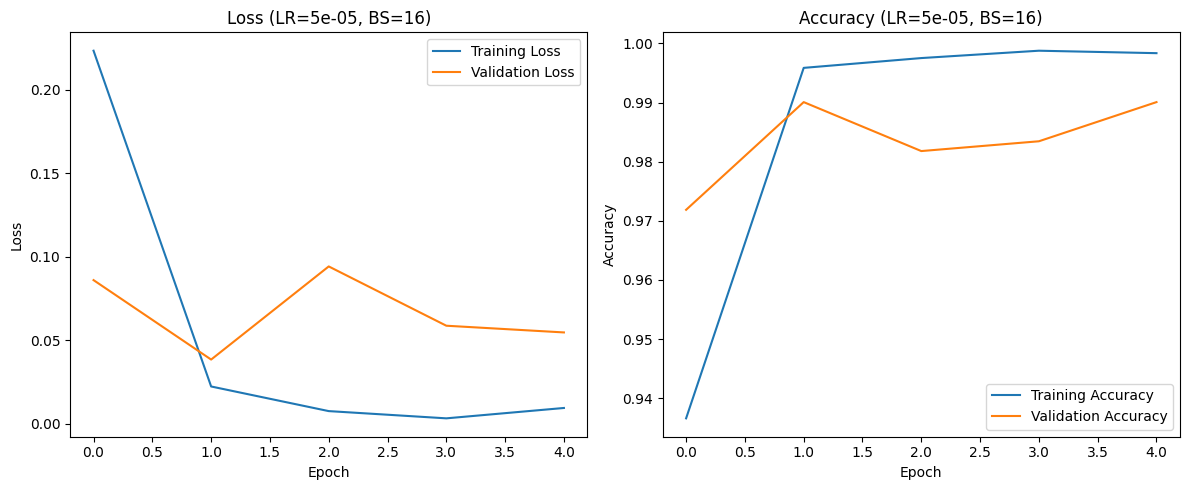


 Final Test Accuracy: 99.01%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.93      1.00      0.97        28
      iot_wemo_on       1.00      0.91      0.95        34
lists_createoradd       0.97      1.00      0.98        62
            query       1.00      1.00      1.00        68
     send_message       1.00      0.97      0.98        32
  transport_query       1.00      1.00      1.00        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 13.84 seconds

 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.2836, Acc: 0.9221, Val Loss: 

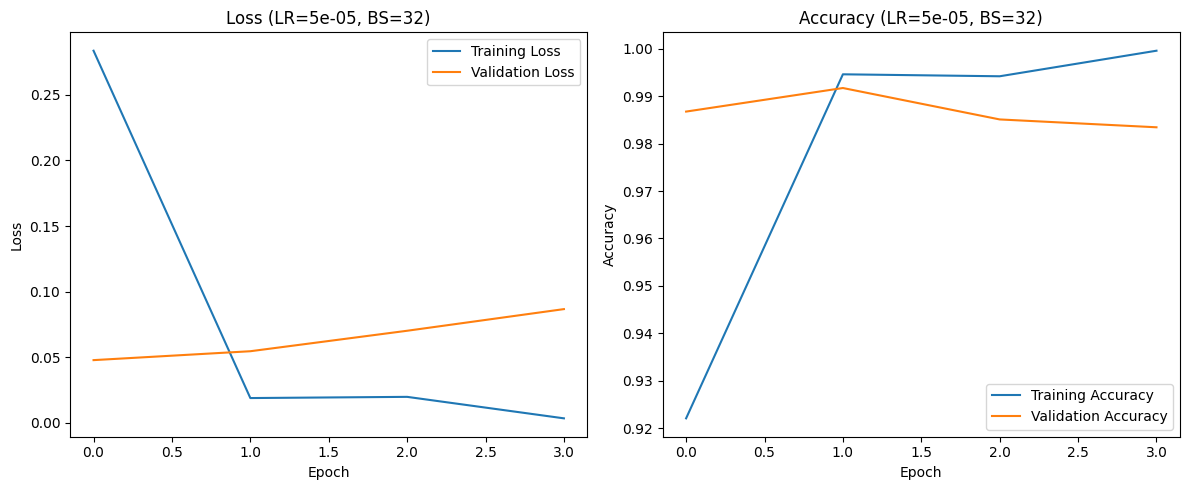


 Final Test Accuracy: 99.01%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.93      1.00      0.97        28
      iot_wemo_on       1.00      0.91      0.95        34
lists_createoradd       0.97      1.00      0.98        62
            query       1.00      1.00      1.00        68
     send_message       1.00      0.97      0.98        32
  transport_query       1.00      1.00      1.00        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 13.84 seconds

 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.4472, Acc: 0.8641, Val Loss: 

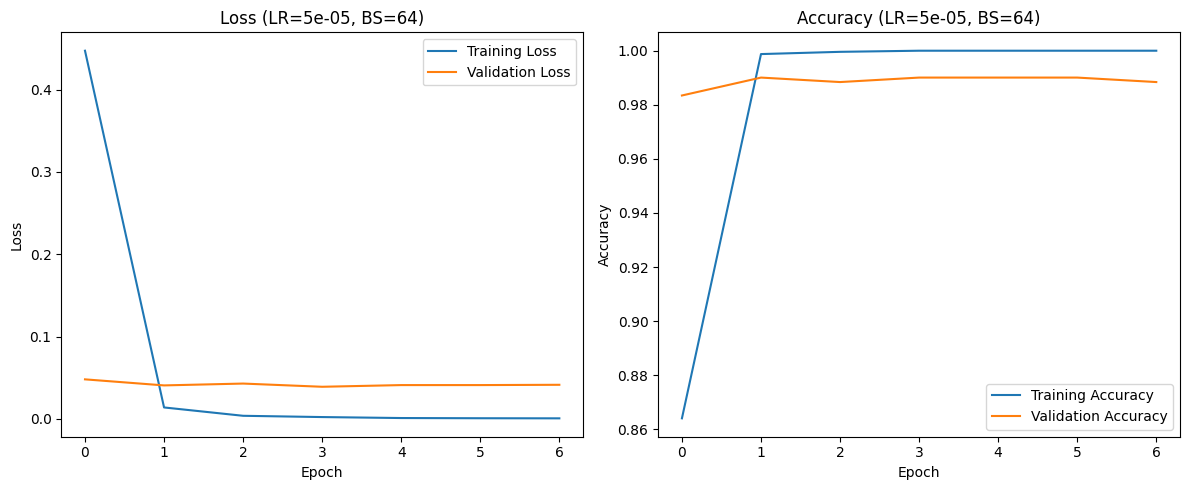


 Final Test Accuracy: 99.01%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.93      1.00      0.97        28
      iot_wemo_on       1.00      0.91      0.95        34
lists_createoradd       0.97      1.00      0.98        62
            query       1.00      1.00      1.00        68
     send_message       1.00      0.97      0.98        32
  transport_query       1.00      1.00      1.00        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 13.84 seconds

 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.3622, Acc: 0.9047, Val Loss: 

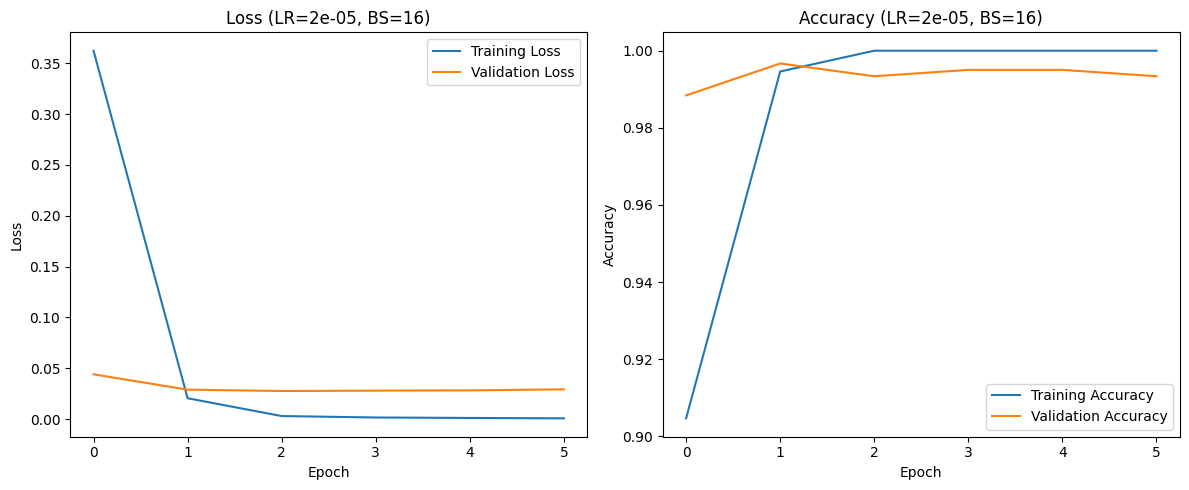


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds

 Training with LR=2e-05, BS=32
Epoch  1, Train Loss: 0.5472, Acc: 0.8512, Val Loss: 

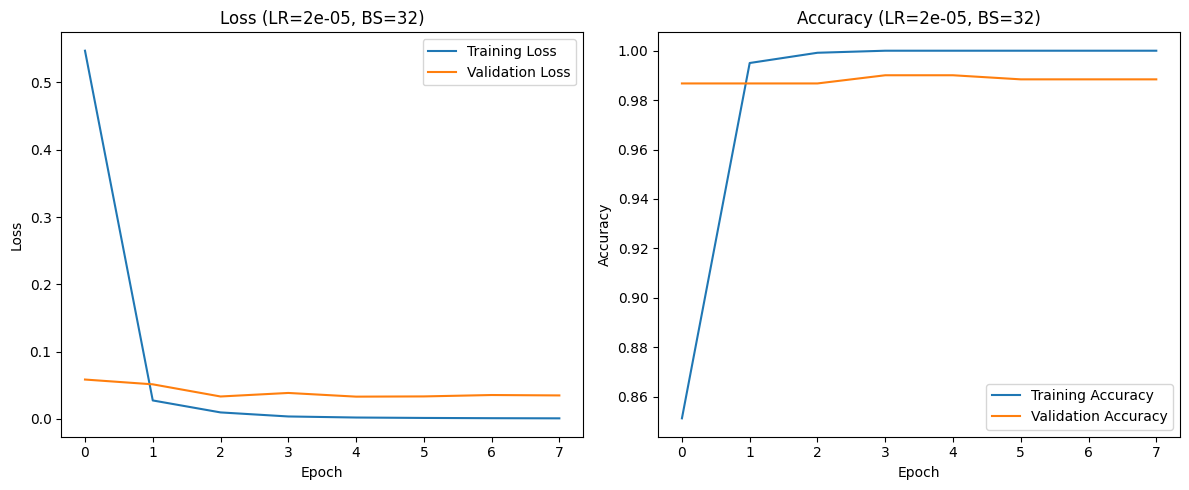


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds

 Training with LR=2e-05, BS=64
Epoch  1, Train Loss: 0.7898, Acc: 0.7882, Val Loss: 

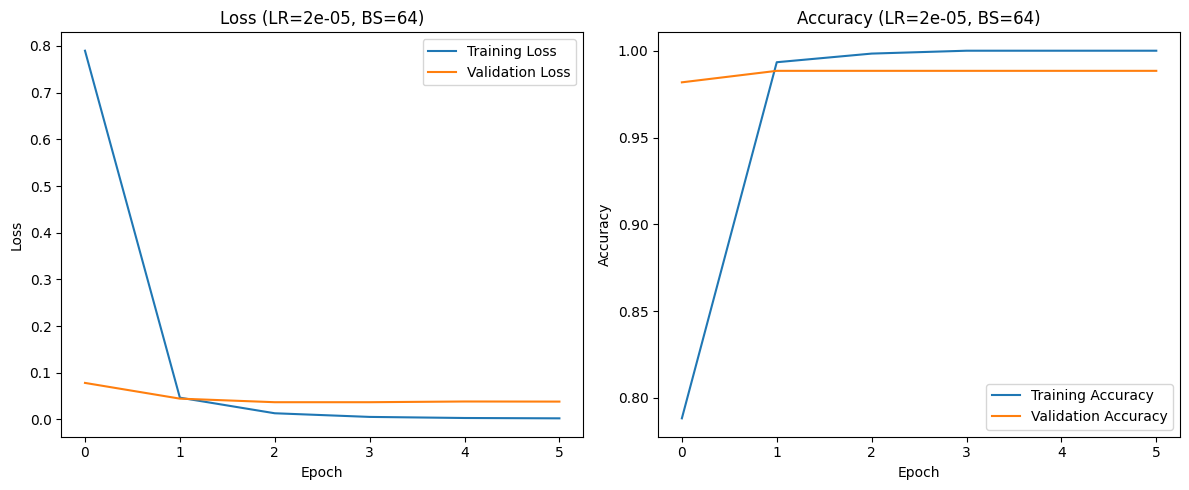


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds

 Training with LR=1e-05, BS=16
Epoch  1, Train Loss: 0.6176, Acc: 0.8392, Val Loss: 

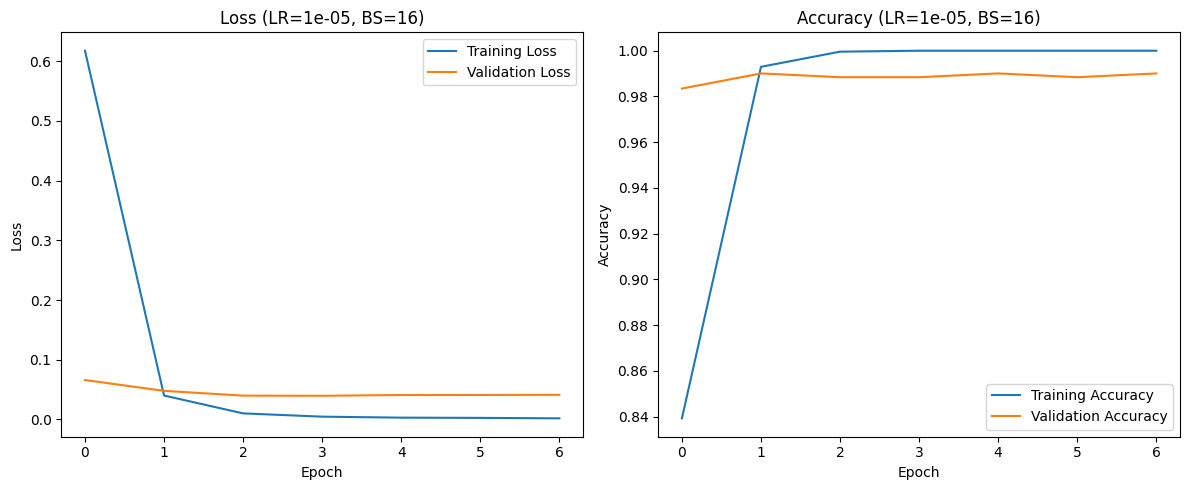


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds

 Training with LR=1e-05, BS=32
Epoch  1, Train Loss: 0.8391, Acc: 0.7862, Val Loss: 

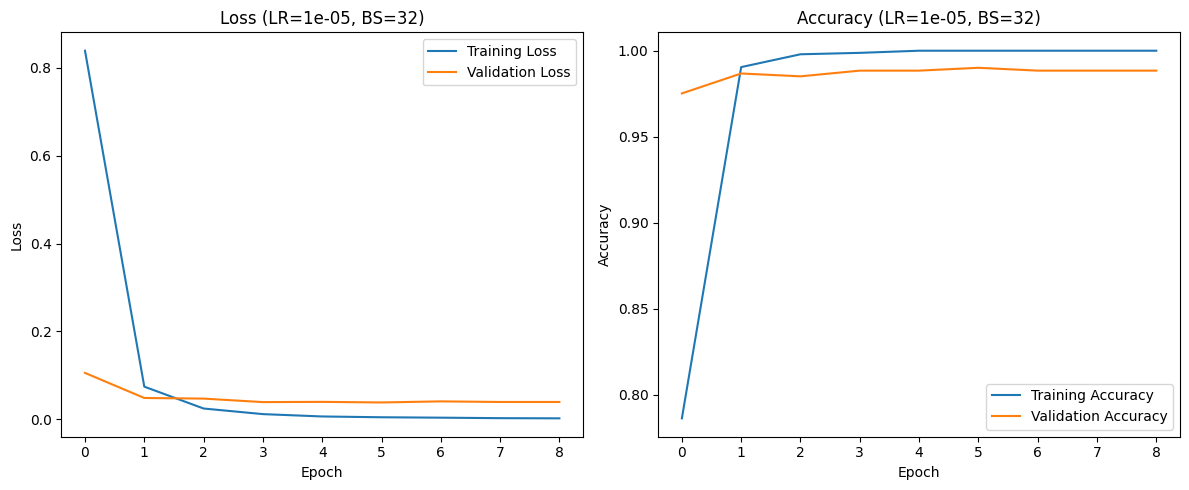


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds

 Training with LR=1e-05, BS=64
Epoch  1, Train Loss: 1.2093, Acc: 0.6755, Val Loss: 

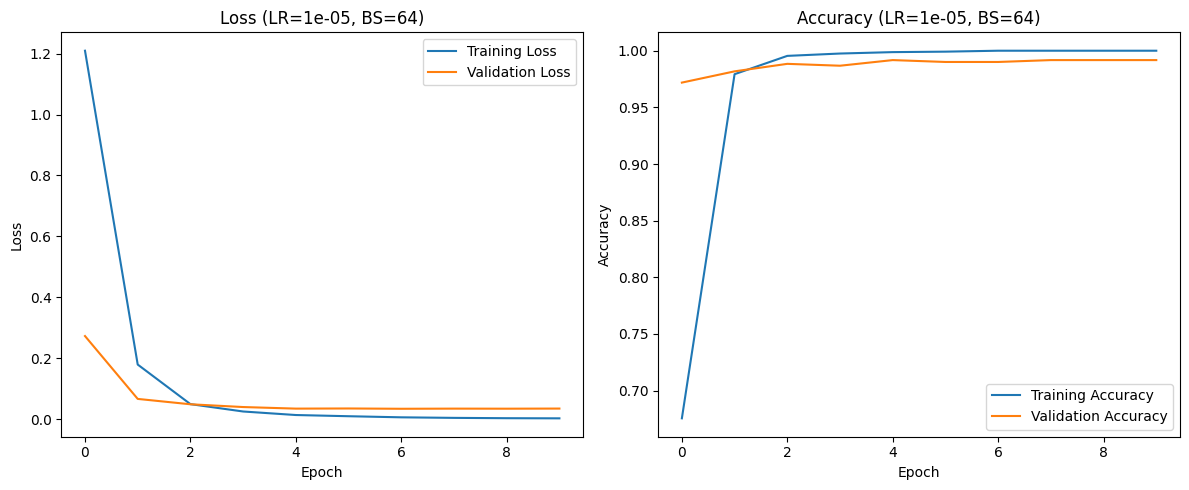


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        43
     calendar_set       0.99      0.99      0.99        89
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      0.97      0.99        34
lists_createoradd       1.00      1.00      1.00        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       0.99      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 20.07 seconds


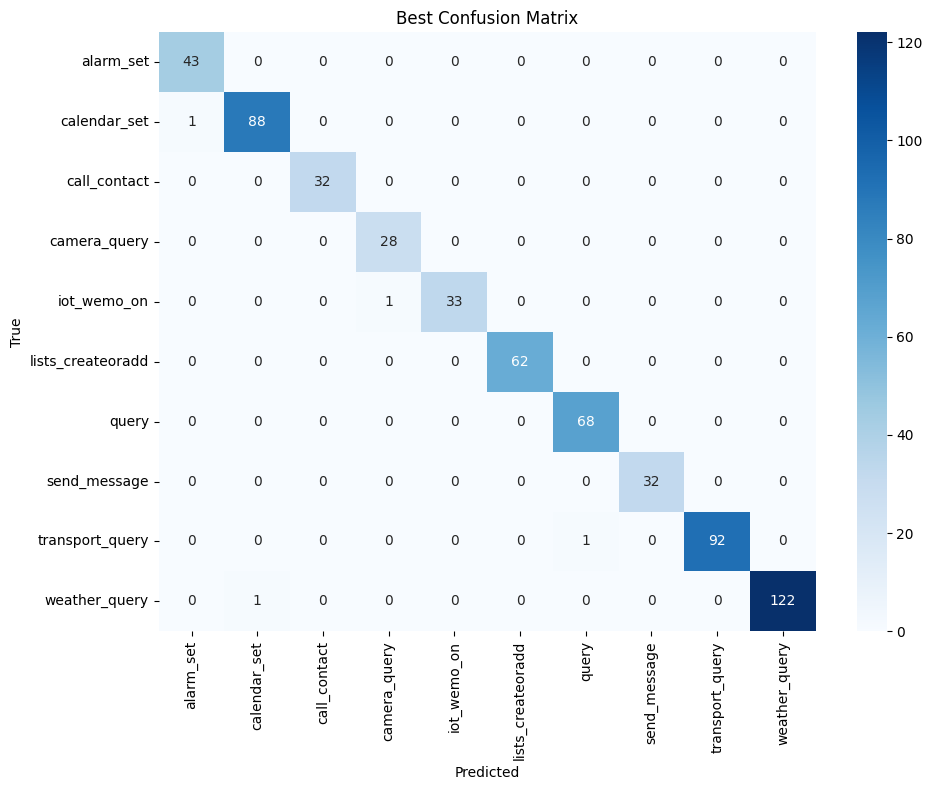

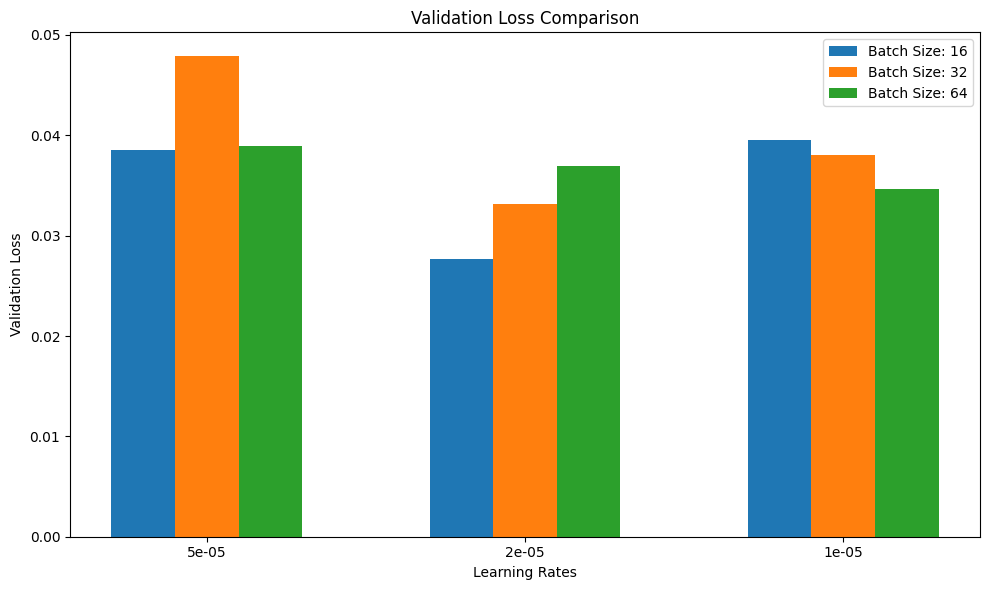

/tmp/ipykernel_1045249/1756765122.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))



========== Fold 2 ==========

 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2235, Acc: 0.9362, Val Loss: 0.0352, Acc: 0.9884
Epoch  2, Train Loss: 0.0156, Acc: 0.9963, Val Loss: 0.0357, Acc: 0.9901
Epoch  3, Train Loss: 0.0029, Acc: 0.9992, Val Loss: 0.0227, Acc: 0.9967
Epoch  4, Train Loss: 0.0006, Acc: 1.0000, Val Loss: 0.0193, Acc: 0.9967
Epoch  5, Train Loss: 0.0004, Acc: 1.0000, Val Loss: 0.0198, Acc: 0.9967
Epoch  6, Train Loss: 0.0003, Acc: 1.0000, Val Loss: 0.0193, Acc: 0.9967
Epoch  7, Train Loss: 0.0003, Acc: 1.0000, Val Loss: 0.0181, Acc: 0.9967
Epoch  8, Train Loss: 0.0002, Acc: 1.0000, Val Loss: 0.0190, Acc: 0.9967
Epoch  9, Train Loss: 0.0002, Acc: 1.0000, Val Loss: 0.0188, Acc: 0.9967
Epoch 10, Train Loss: 0.0030, Acc: 0.9996, Val Loss: 0.7936, Acc: 0.9123
Early stopping.


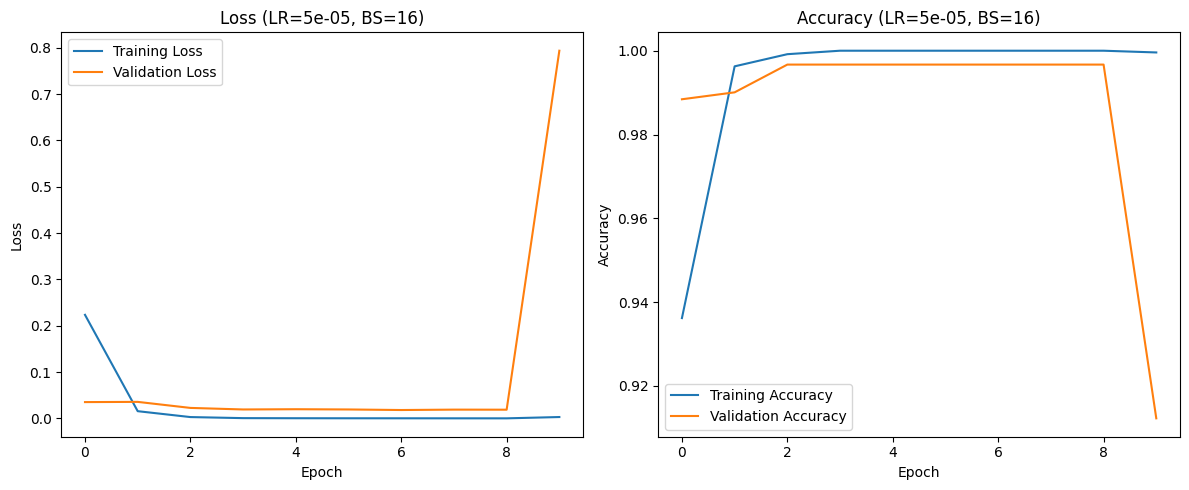


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.2824, Acc: 0.9188, Val Loss: 

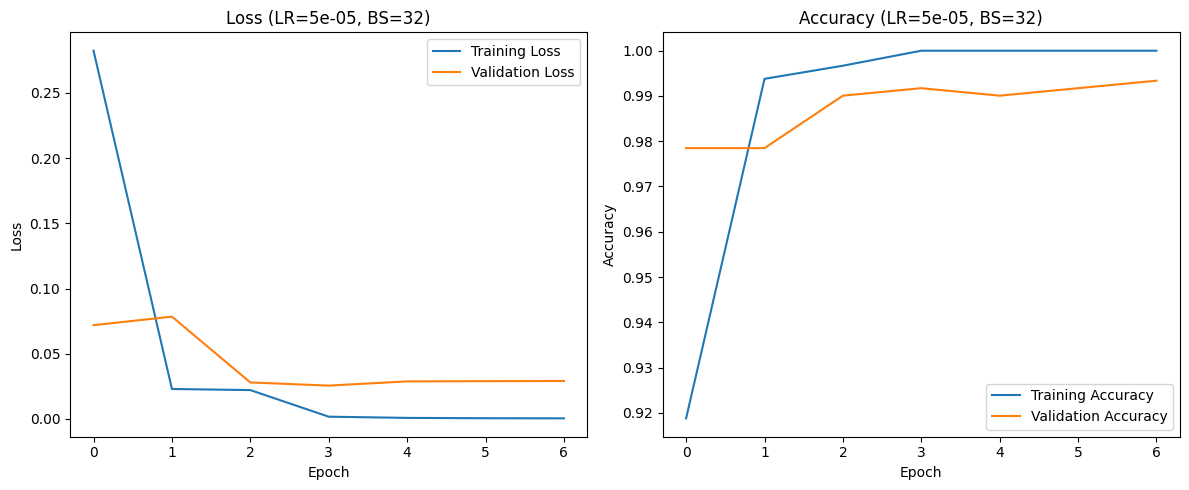


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.3979, Acc: 0.8864, Val Loss: 

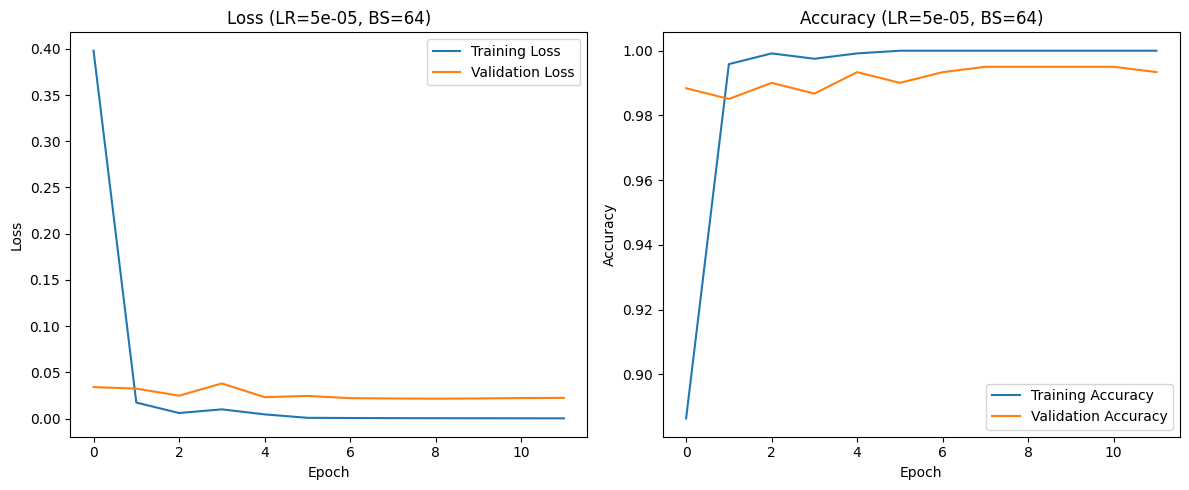


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.3802, Acc: 0.8997, Val Loss: 

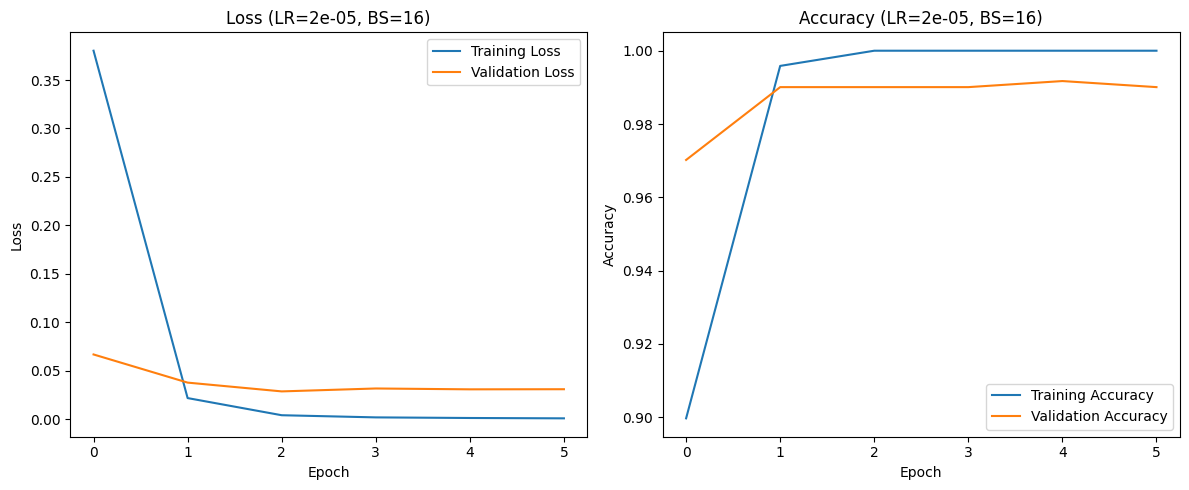


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=2e-05, BS=32
Epoch  1, Train Loss: 0.5569, Acc: 0.8471, Val Loss: 

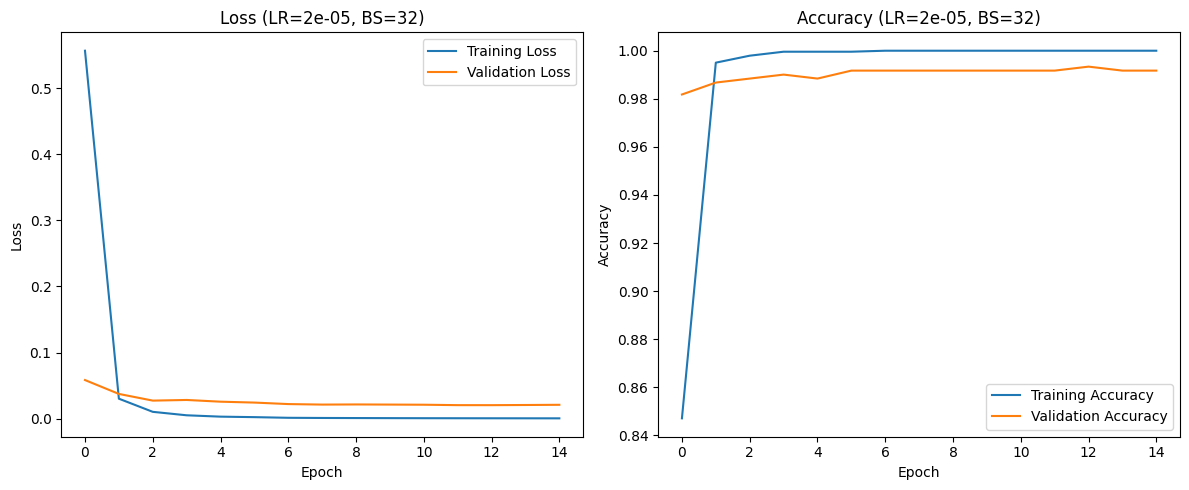


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=2e-05, BS=64
Epoch  1, Train Loss: 0.7818, Acc: 0.7812, Val Loss: 

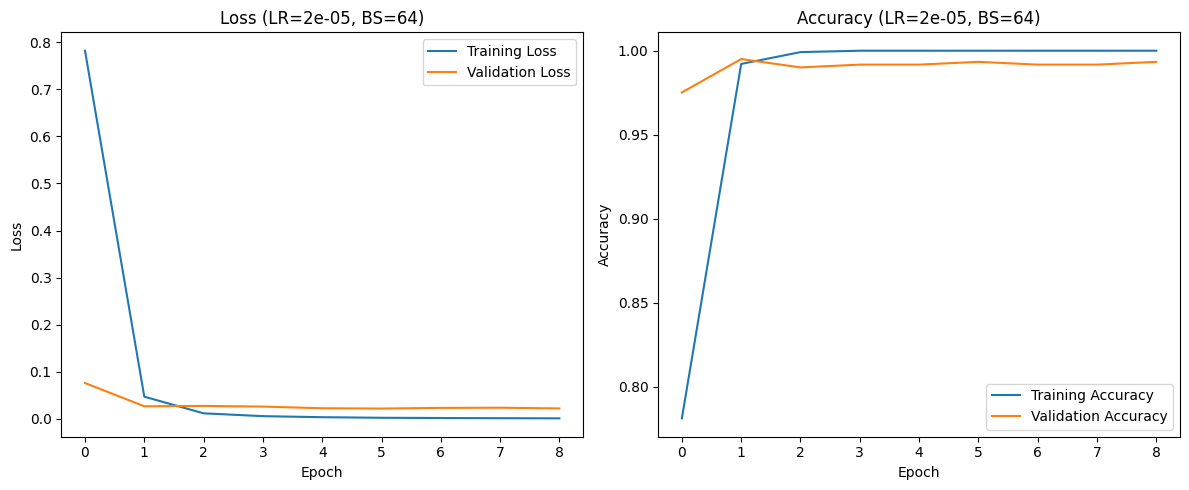


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=1e-05, BS=16
Epoch  1, Train Loss: 0.5901, Acc: 0.8537, Val Loss: 

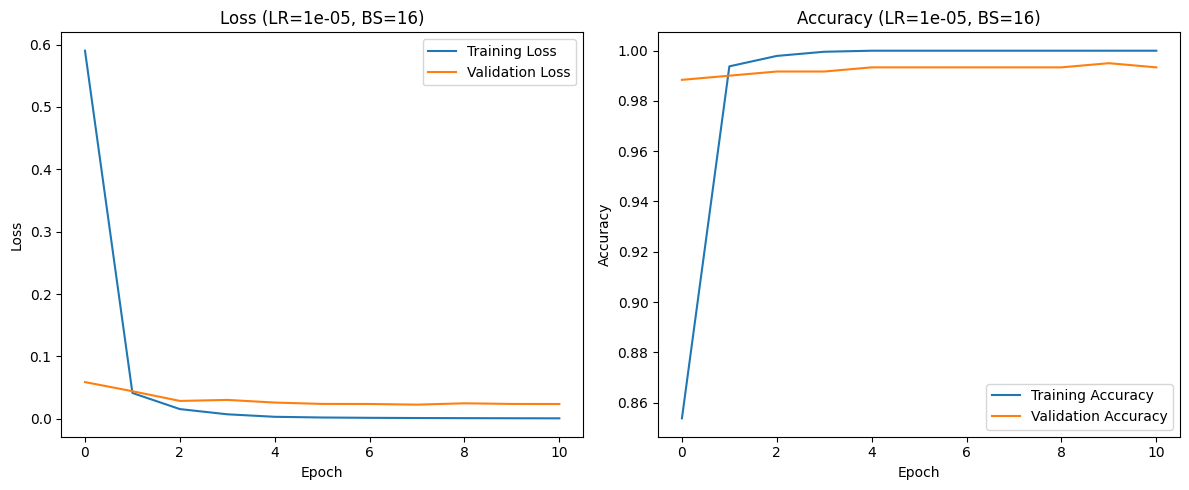


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=1e-05, BS=32
Epoch  1, Train Loss: 0.9041, Acc: 0.7522, Val Loss: 

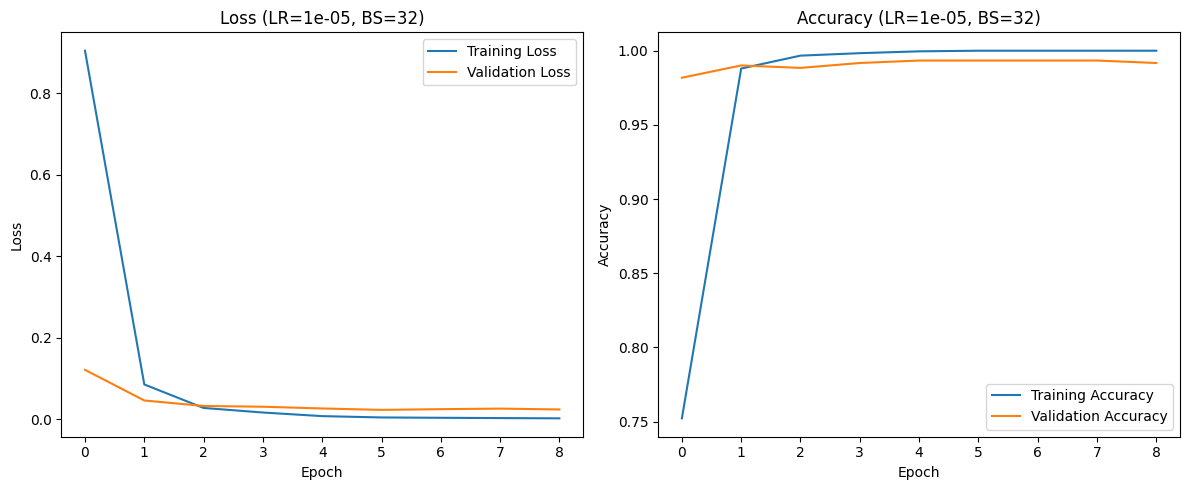


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      1.00      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      1.00      0.99        93
    weather_query       1.00      0.98      0.99       123

         accuracy                           1.00       604
        macro avg       1.00      1.00      1.00       604
     weighted avg       1.00      1.00      1.00       604


 Response Time: 46.94 seconds

 Training with LR=1e-05, BS=64
Epoch  1, Train Loss: 1.2188, Acc: 0.6689, Val Loss: 

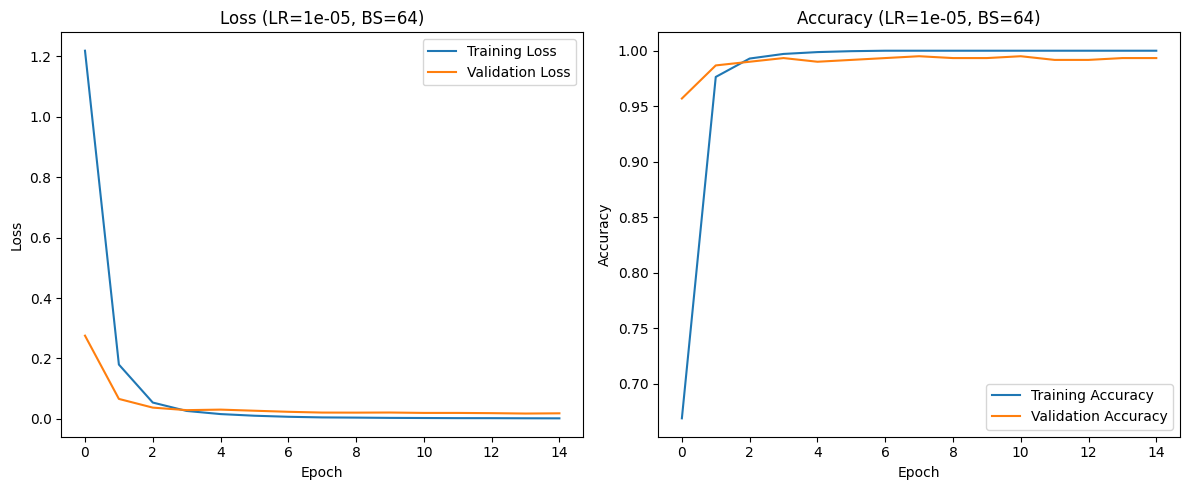


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        43
     calendar_set       0.99      1.00      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      0.97      0.98        33
lists_createoradd       0.98      0.98      0.98        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.98      0.99      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       604
        macro avg       1.00      0.99      0.99       604
     weighted avg       0.99      0.99      0.99       604


 Response Time: 53.37 seconds


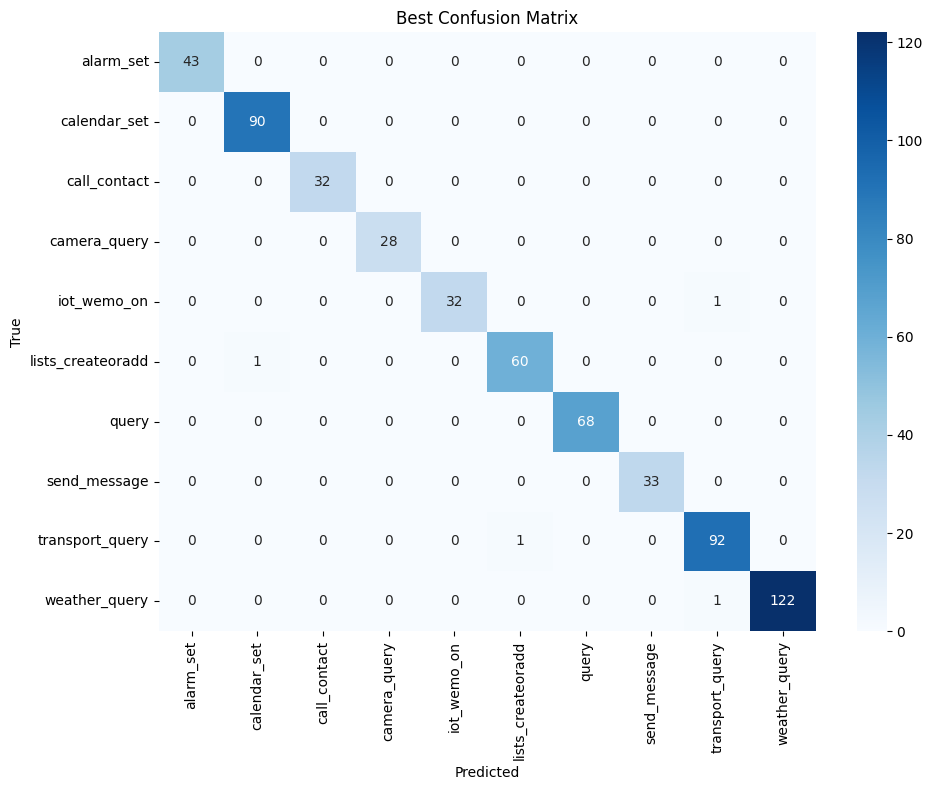

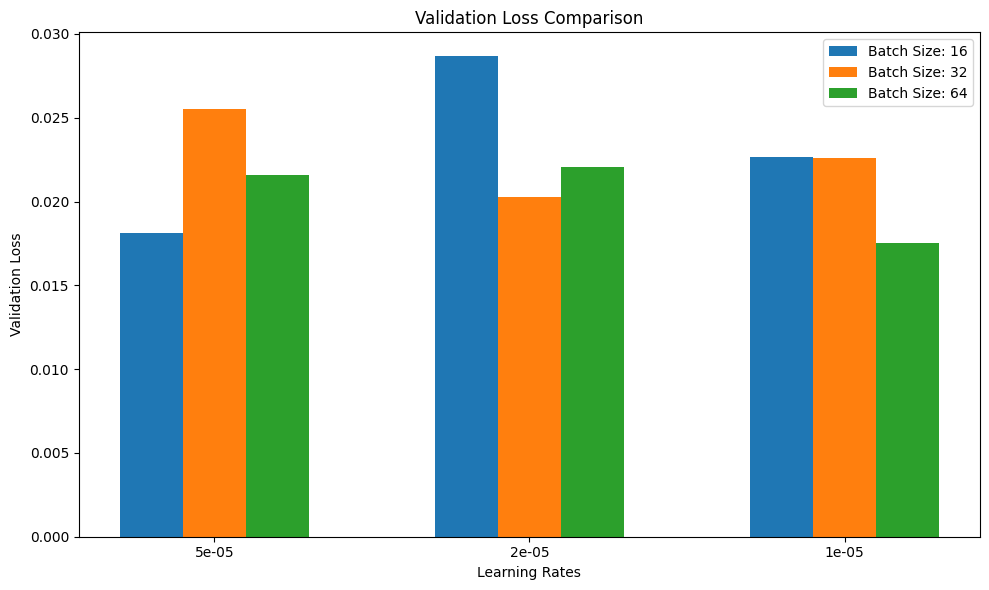

/tmp/ipykernel_1045249/1756765122.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))



========== Fold 3 ==========

 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2235, Acc: 0.9366, Val Loss: 0.0345, Acc: 0.9950
Epoch  2, Train Loss: 0.0163, Acc: 0.9954, Val Loss: 0.0346, Acc: 0.9900
Epoch  3, Train Loss: 0.0077, Acc: 0.9975, Val Loss: 0.0322, Acc: 0.9934
Epoch  4, Train Loss: 0.0061, Acc: 0.9983, Val Loss: 0.0472, Acc: 0.9884
Epoch  5, Train Loss: 0.0028, Acc: 0.9992, Val Loss: 0.0412, Acc: 0.9934
Epoch  6, Train Loss: 0.0144, Acc: 0.9959, Val Loss: 0.0435, Acc: 0.9900
Early stopping.


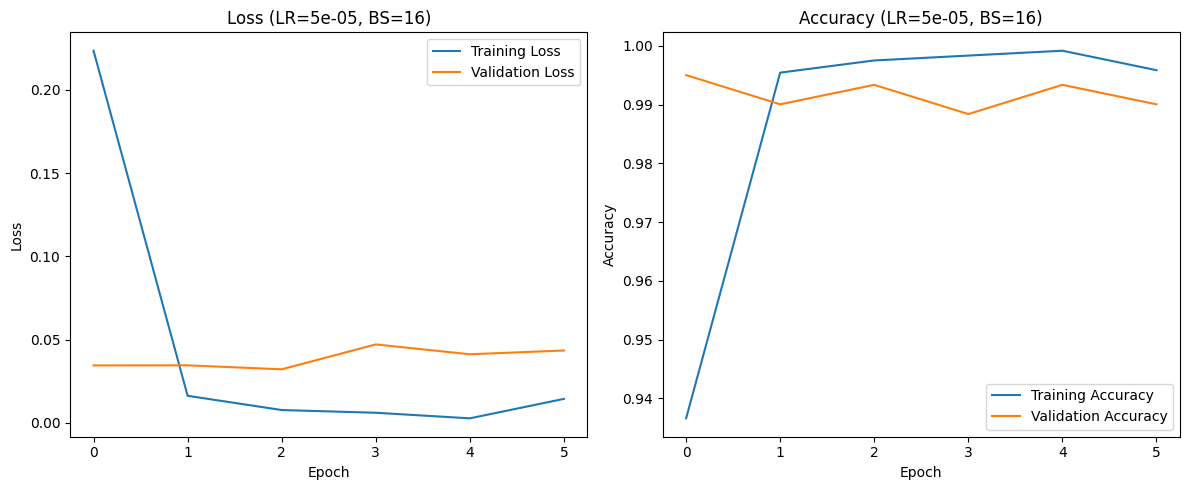


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       0.99      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      0.98      0.98        61
            query       1.00      1.00      1.00        68
     send_message       0.97      1.00      0.99        33
  transport_query       1.00      0.98      0.99        93
    weather_query       0.99      1.00      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 18.23 seconds

 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.2716, Acc: 0.9221, Val Loss: 

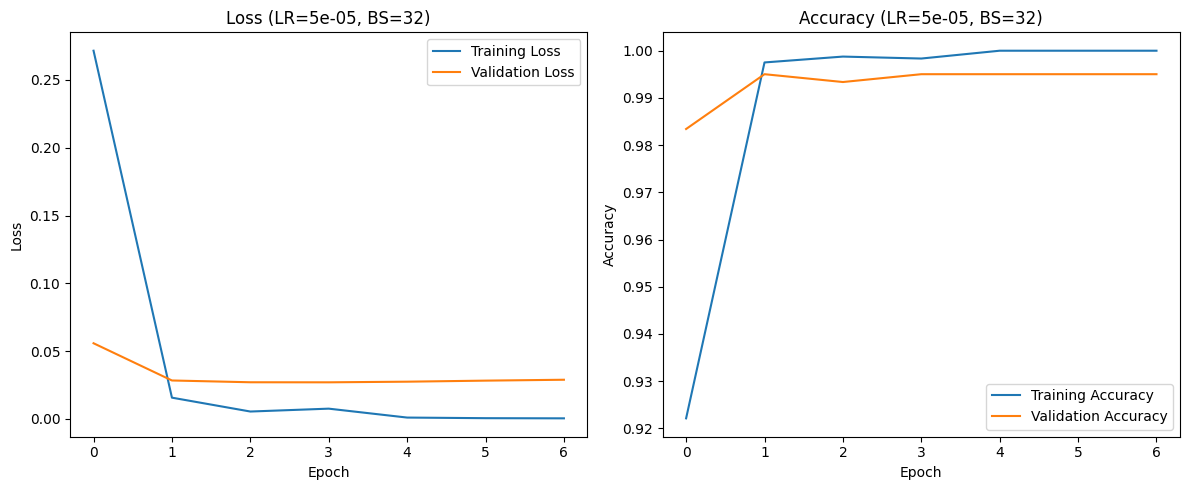


 Final Test Accuracy: 99.50%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      0.98      0.98        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.99      0.99        93
    weather_query       0.99      0.99      0.99       123

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 16.67 seconds

 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.4350, Acc: 0.8695, Val Loss: 

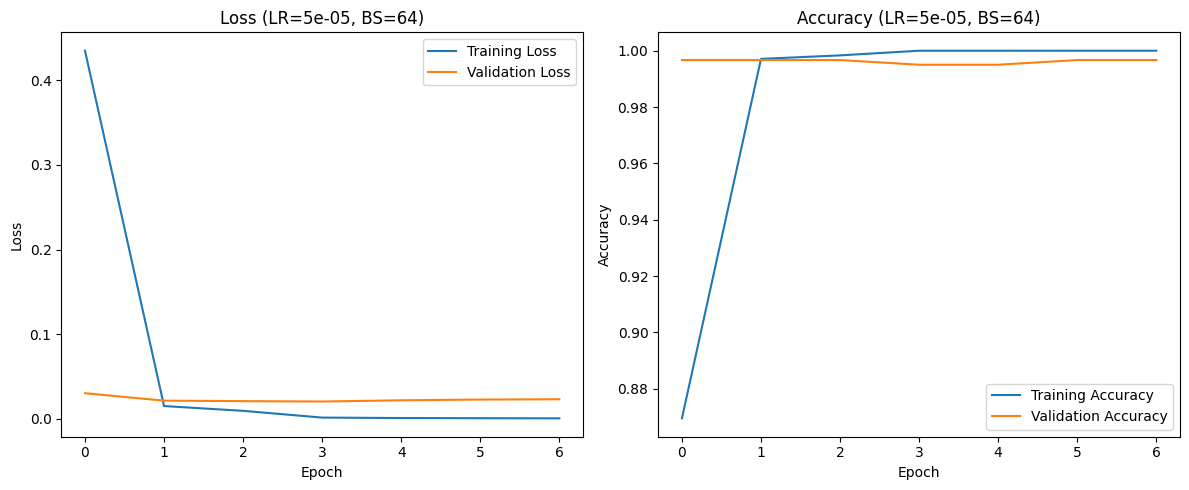


 Final Test Accuracy: 99.50%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       0.98      0.98      0.98        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.99      0.99        93
    weather_query       0.99      0.99      0.99       123

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 13.67 seconds

 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.3817, Acc: 0.8985, Val Loss: 

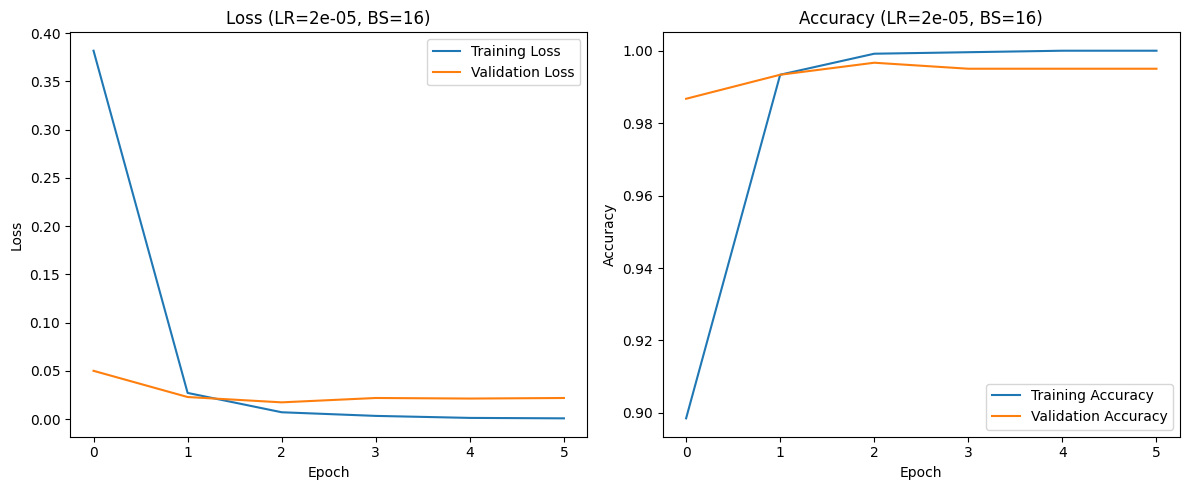


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       0.99      1.00      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      0.98      0.99        61
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        93
    weather_query       1.00      1.00      1.00       123

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 18.12 seconds

 Training with LR=2e-05, BS=32
Epoch  1, Train Loss: 0.5198, Acc: 0.8575, Val Loss: 

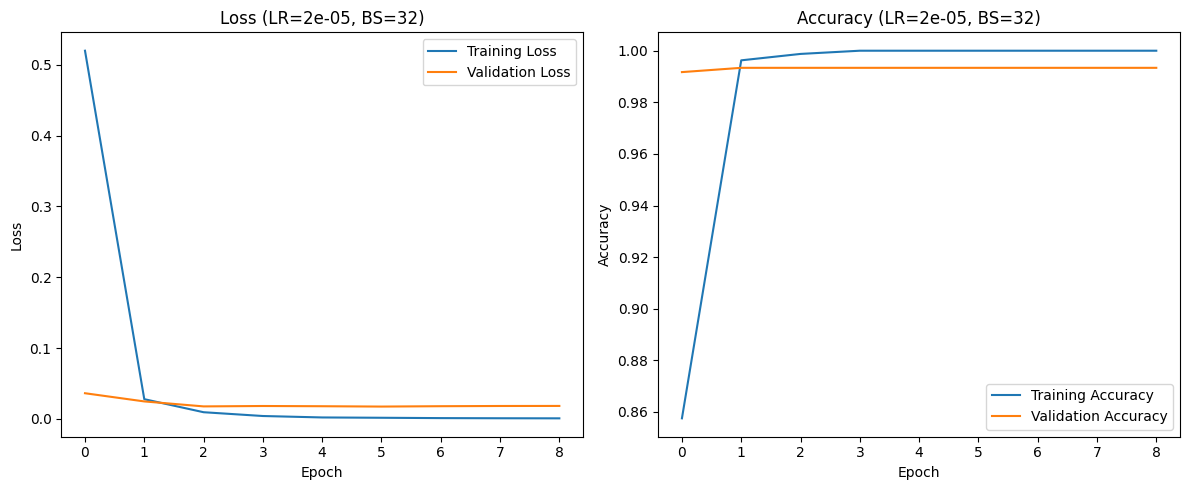


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       0.98      0.98      0.98        61
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.98      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 22.78 seconds

 Training with LR=2e-05, BS=64
Epoch  1, Train Loss: 0.8155, Acc: 0.7792, Val Loss: 

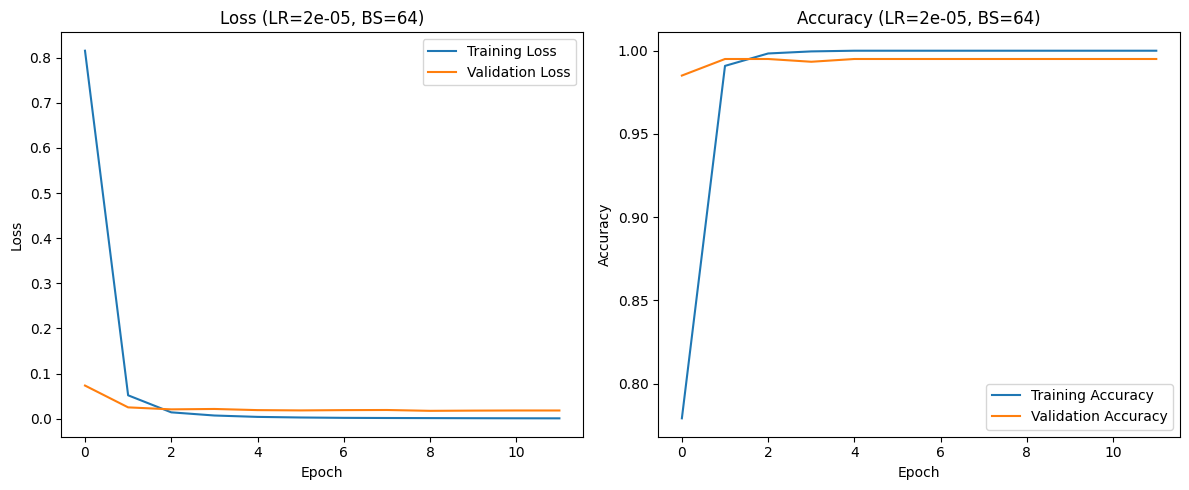


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       0.98      0.98      0.98        61
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.98      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 22.78 seconds

 Training with LR=1e-05, BS=16
Epoch  1, Train Loss: 0.6039, Acc: 0.8442, Val Loss: 

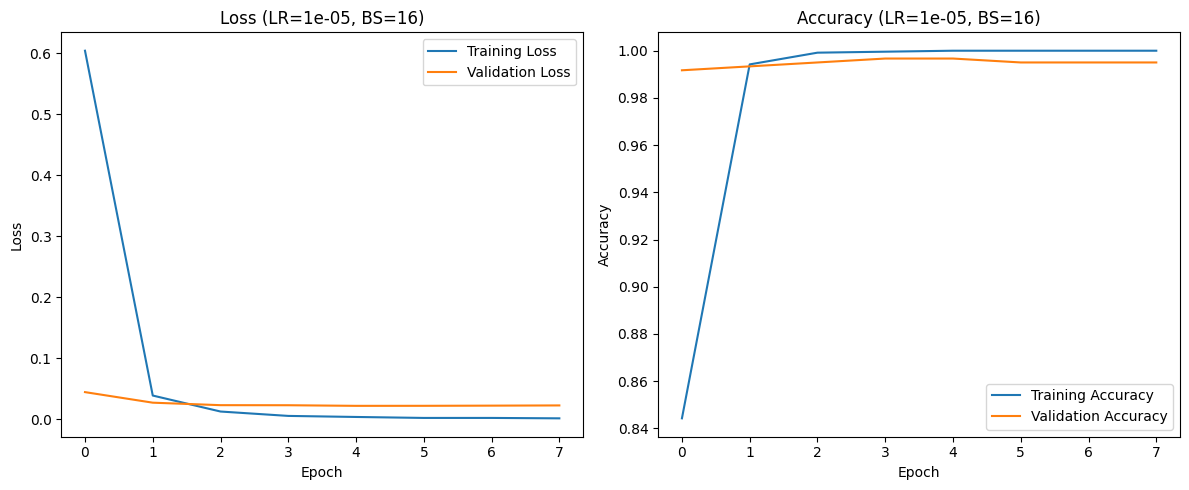


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       0.98      0.98      0.98        61
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.98      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 22.78 seconds

 Training with LR=1e-05, BS=32
Epoch  1, Train Loss: 0.8514, Acc: 0.7717, Val Loss: 

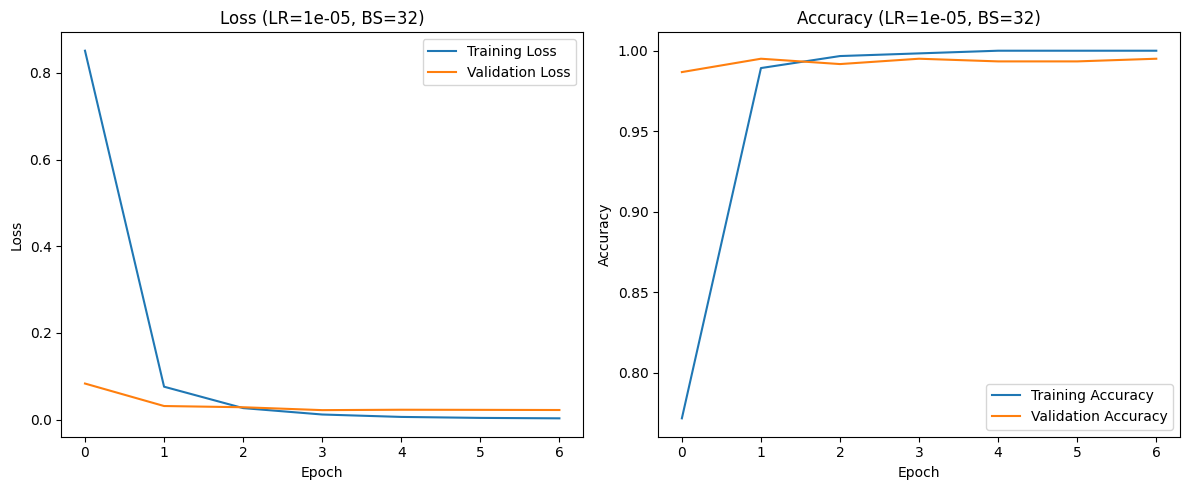


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       0.98      0.98      0.98        61
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.98      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 22.78 seconds

 Training with LR=1e-05, BS=64
Epoch  1, Train Loss: 1.3818, Acc: 0.5949, Val Loss: 

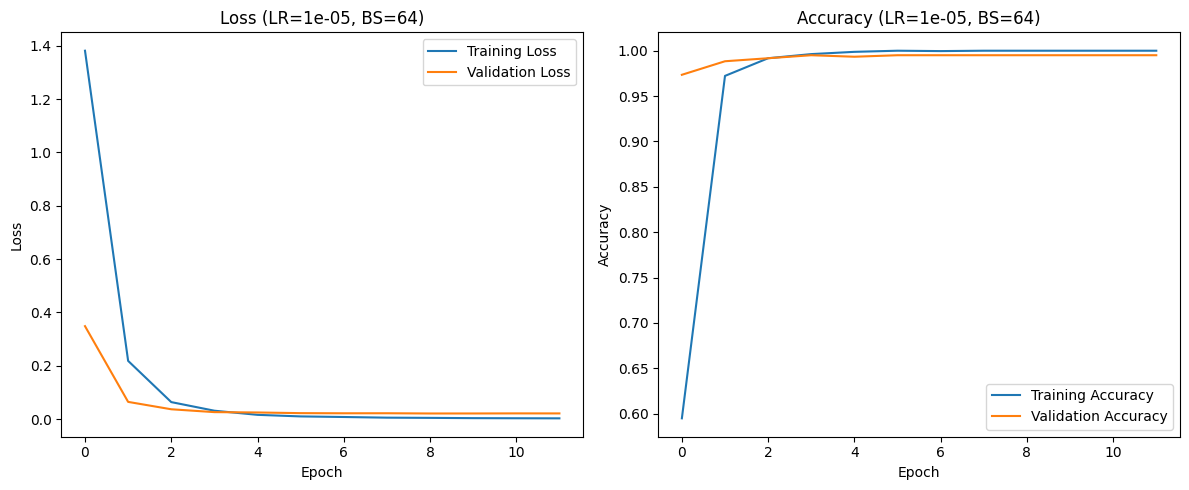


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       0.98      0.98      0.98        61
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        33
  transport_query       0.99      0.98      0.98        93
    weather_query       1.00      0.99      1.00       123

         accuracy                           0.99       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 22.78 seconds


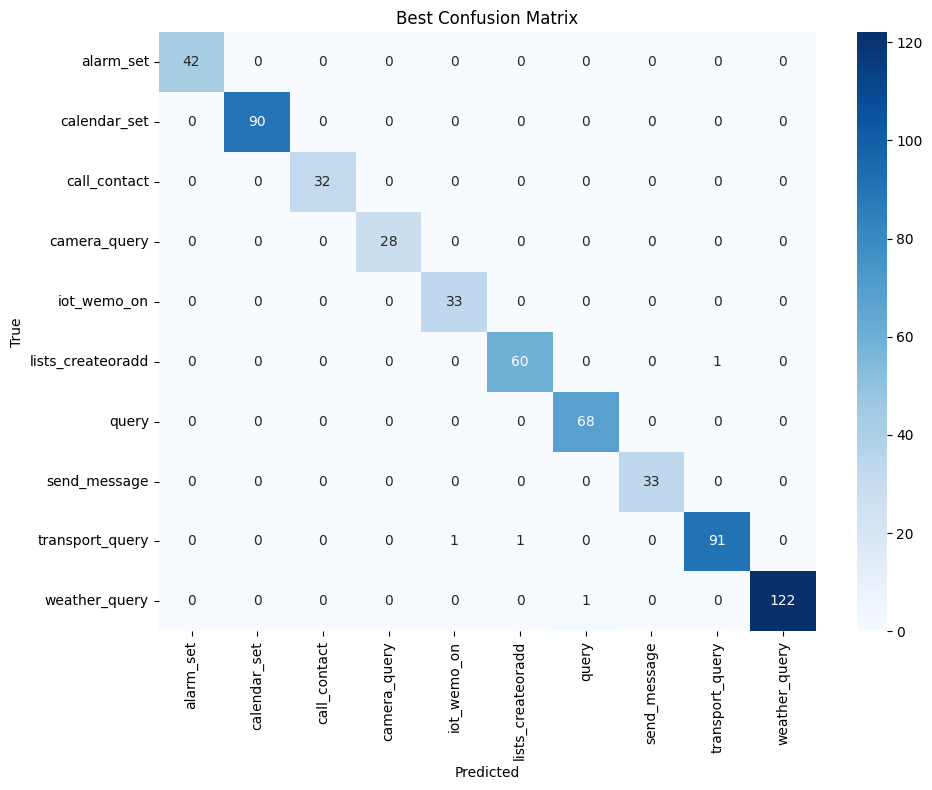

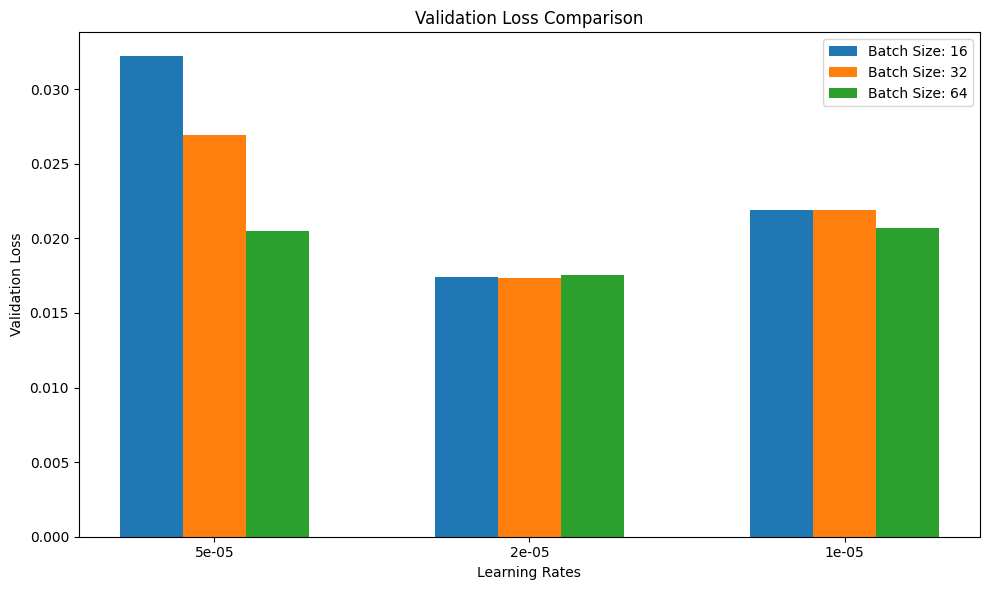

/tmp/ipykernel_1045249/1756765122.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))



========== Fold 4 ==========

 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2170, Acc: 0.9325, Val Loss: 0.0380, Acc: 0.9934
Epoch  2, Train Loss: 0.0412, Acc: 0.9909, Val Loss: 0.0500, Acc: 0.9867
Epoch  3, Train Loss: 0.0061, Acc: 0.9996, Val Loss: 0.0398, Acc: 0.9934
Epoch  4, Train Loss: 0.0035, Acc: 0.9996, Val Loss: 0.0394, Acc: 0.9934
Early stopping.


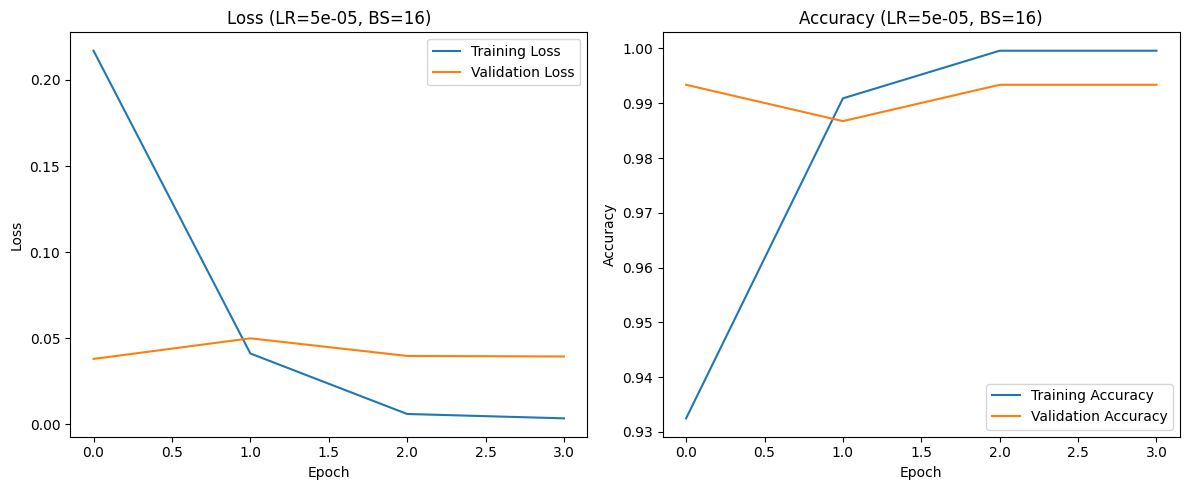


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       0.97      1.00      0.99        33
lists_createoradd       1.00      0.98      0.99        62
            query       1.00      0.99      0.99        68
     send_message       0.97      1.00      0.99        33
  transport_query       1.00      1.00      1.00        92
    weather_query       0.99      0.99      0.99       123

         accuracy                           0.99       603
        macro avg       0.99      0.99      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 7.05 seconds

 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.2819, Acc: 0.9200, Val Loss: 0

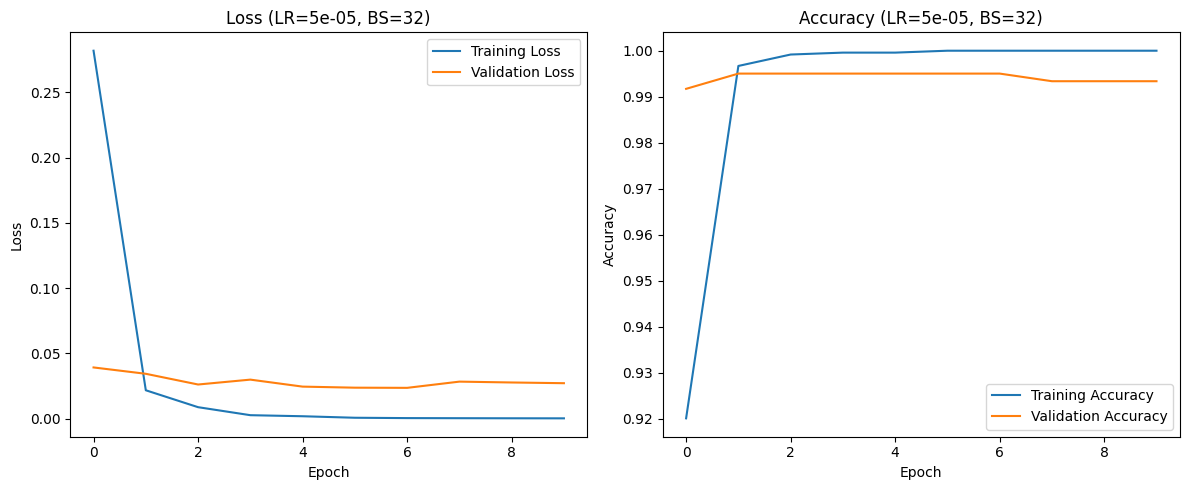


 Final Test Accuracy: 99.50%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       0.98      1.00      0.99        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       0.97      1.00      0.98        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      0.98      0.99        62
            query       1.00      1.00      1.00        68
     send_message       0.97      1.00      0.99        33
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      0.99       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 34.35 seconds

 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.4192, Acc: 0.8824, Val Loss: 

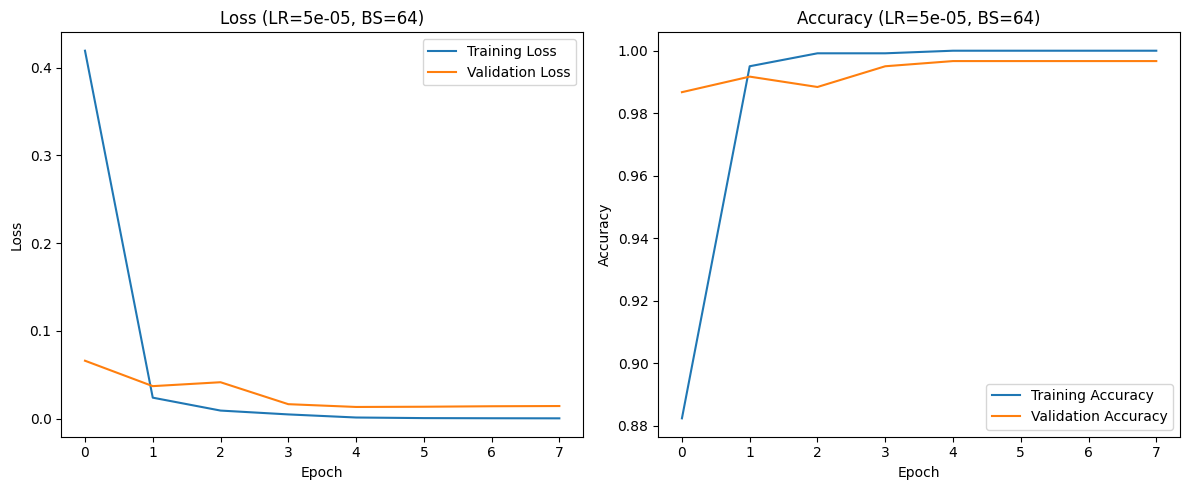


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.3677, Acc: 0.9043, Val Loss: 

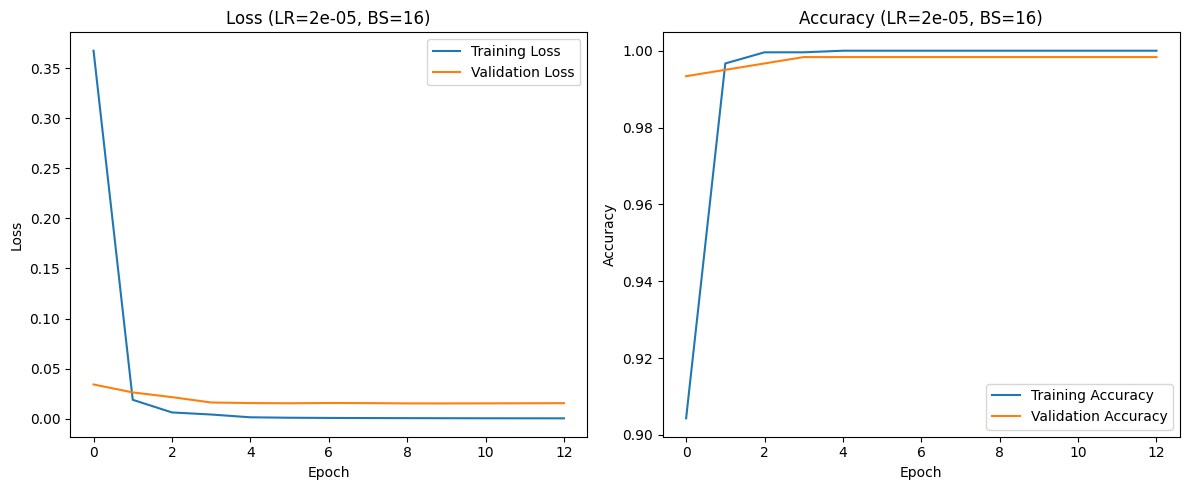


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=2e-05, BS=32
Epoch  1, Train Loss: 0.4991, Acc: 0.8612, Val Loss: 

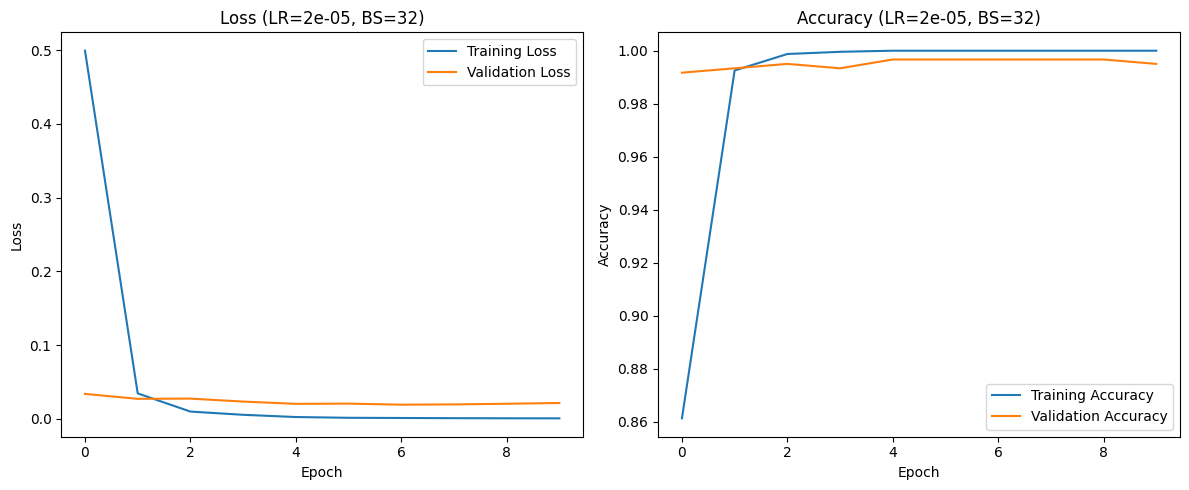


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=2e-05, BS=64
Epoch  1, Train Loss: 0.7328, Acc: 0.8024, Val Loss: 

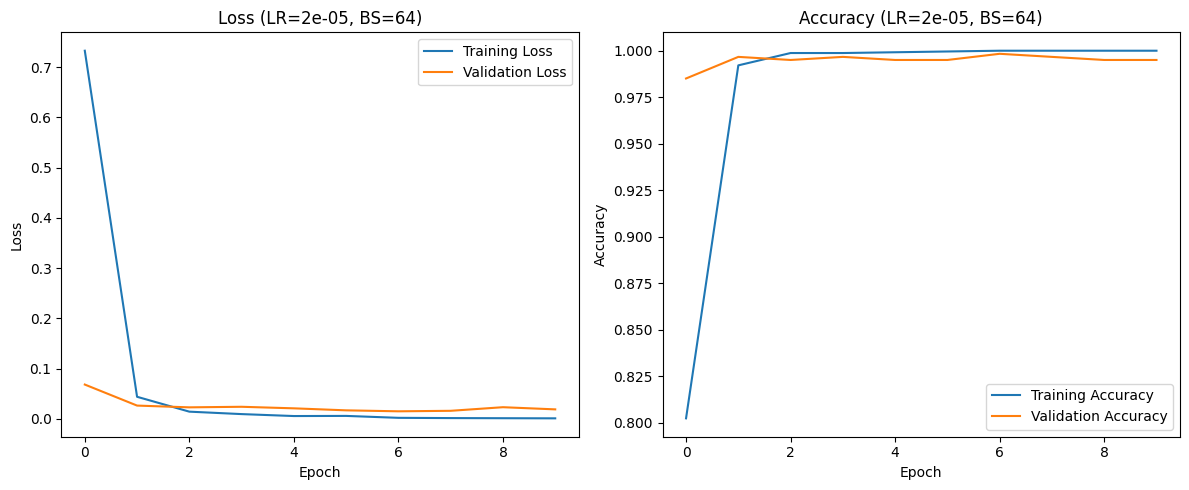


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=1e-05, BS=16
Epoch  1, Train Loss: 0.5865, Acc: 0.8447, Val Loss: 

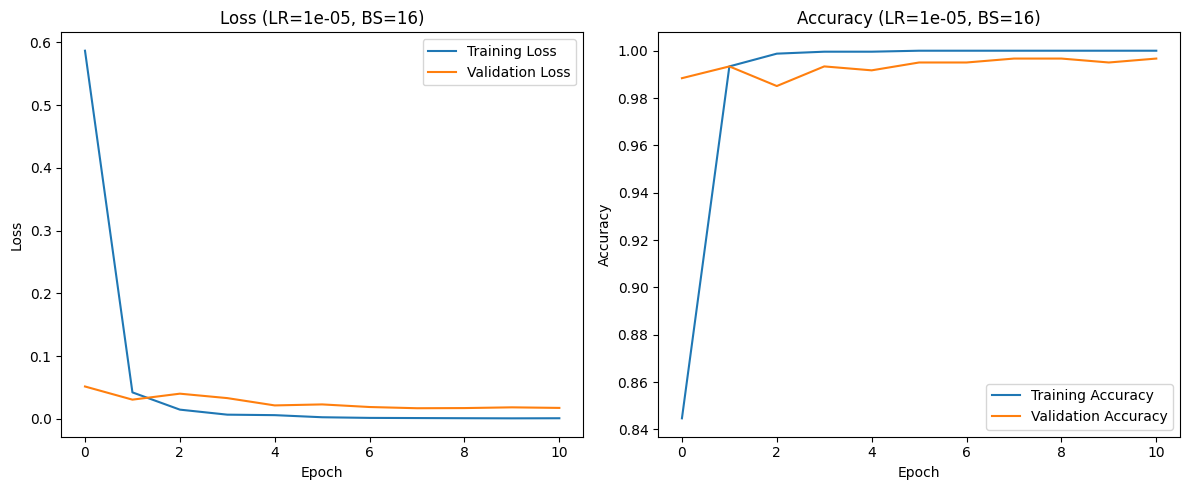


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=1e-05, BS=32
Epoch  1, Train Loss: 0.8379, Acc: 0.7780, Val Loss: 

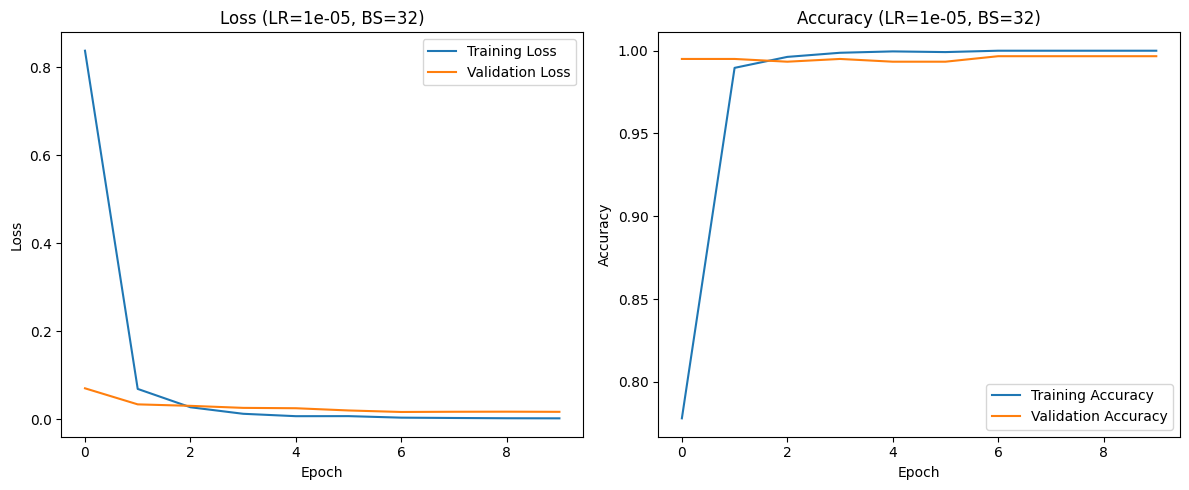


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds

 Training with LR=1e-05, BS=64
Epoch  1, Train Loss: 1.1873, Acc: 0.6698, Val Loss: 

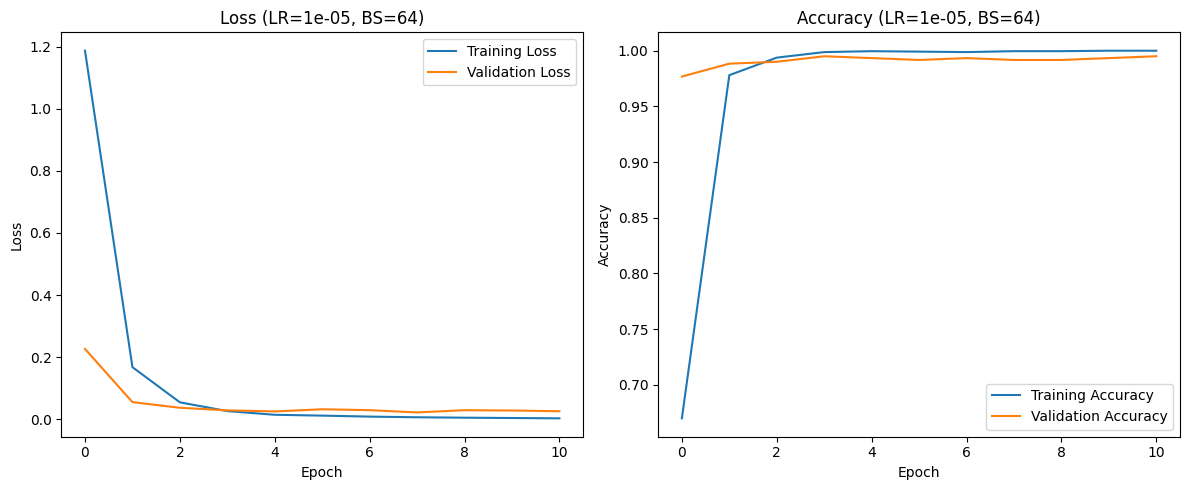


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      1.00      1.00        90
     call_contact       0.94      1.00      0.97        32
     camera_query       1.00      1.00      1.00        28
      iot_wemo_on       1.00      1.00      1.00        33
lists_createoradd       1.00      1.00      1.00        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        33
  transport_query       1.00      0.99      0.99        92
    weather_query       1.00      0.99      1.00       123

         accuracy                           1.00       603
        macro avg       0.99      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 20.09 seconds


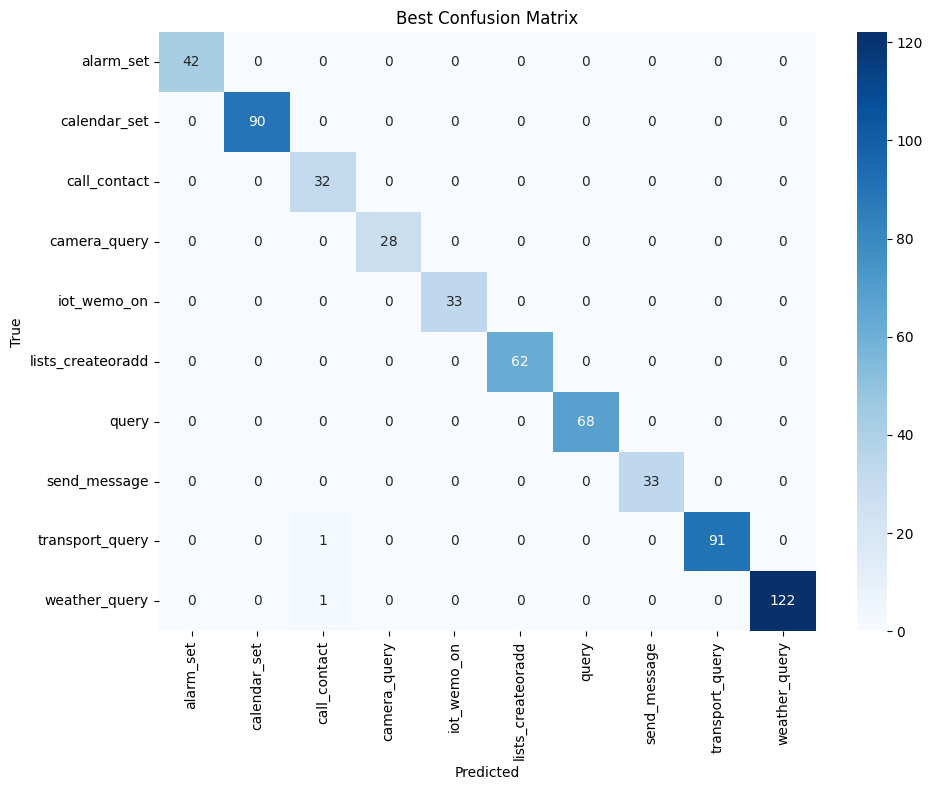

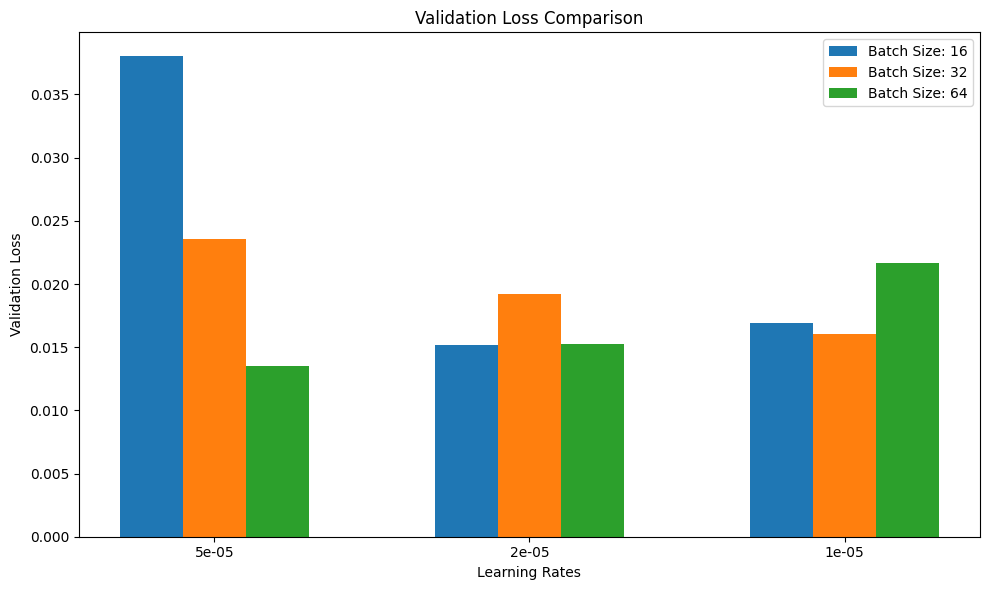

/tmp/ipykernel_1045249/1756765122.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))



========== Fold 5 ==========

 Training with LR=5e-05, BS=16
Epoch  1, Train Loss: 0.2423, Acc: 0.9358, Val Loss: 0.0403, Acc: 0.9801
Epoch  2, Train Loss: 0.0143, Acc: 0.9975, Val Loss: 0.0617, Acc: 0.9735
Epoch  3, Train Loss: 0.0101, Acc: 0.9967, Val Loss: 0.0457, Acc: 0.9900
Epoch  4, Train Loss: 0.0007, Acc: 1.0000, Val Loss: 0.0476, Acc: 0.9900
Early stopping.


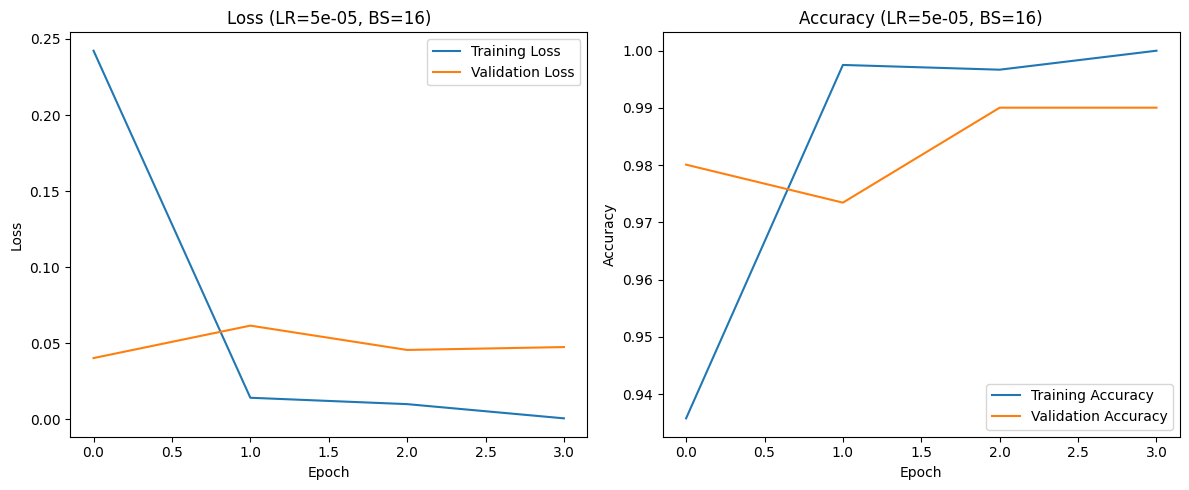


 Final Test Accuracy: 98.01%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       0.94      0.99      0.96        90
     call_contact       1.00      0.97      0.98        32
     camera_query       1.00      0.93      0.96        29
      iot_wemo_on       0.94      1.00      0.97        34
lists_createoradd       1.00      0.92      0.96        62
            query       1.00      1.00      1.00        68
     send_message       0.97      0.97      0.97        32
  transport_query       0.99      0.99      0.99        92
    weather_query       0.98      0.99      0.99       122

         accuracy                           0.98       603
        macro avg       0.98      0.98      0.98       603
     weighted avg       0.98      0.98      0.98       603


 Response Time: 7.00 seconds

 Training with LR=5e-05, BS=32
Epoch  1, Train Loss: 0.2640, Acc: 0.9308, Val Loss: 0

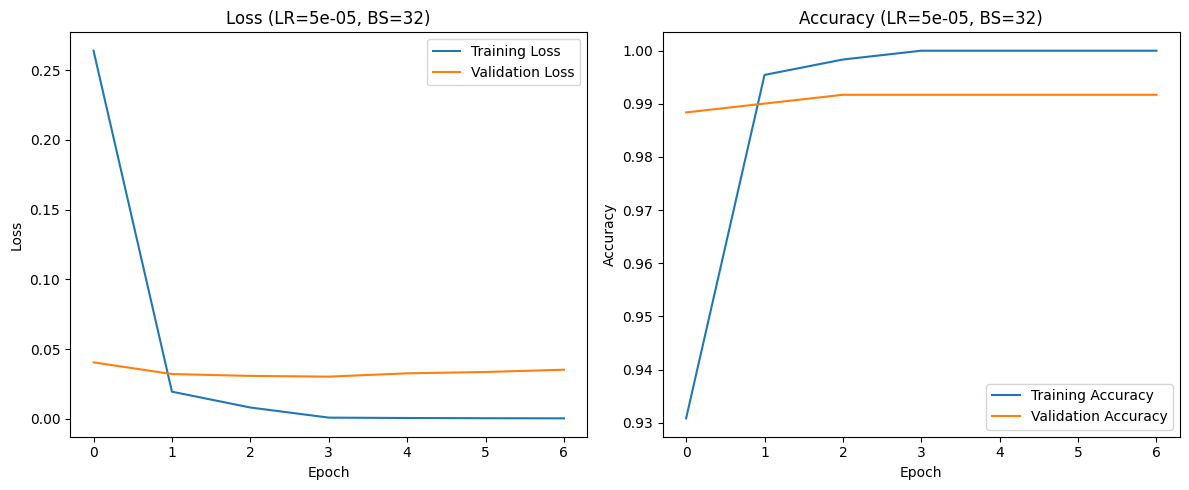


 Final Test Accuracy: 99.17%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.95      0.97        62
            query       0.99      1.00      0.99        68
     send_message       0.97      1.00      0.98        32
  transport_query       1.00      1.00      1.00        92
    weather_query       0.98      0.99      0.99       122

         accuracy                           0.99       603
        macro avg       0.99      0.99      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 19.68 seconds

 Training with LR=5e-05, BS=64
Epoch  1, Train Loss: 0.3827, Acc: 0.8853, Val Loss: 

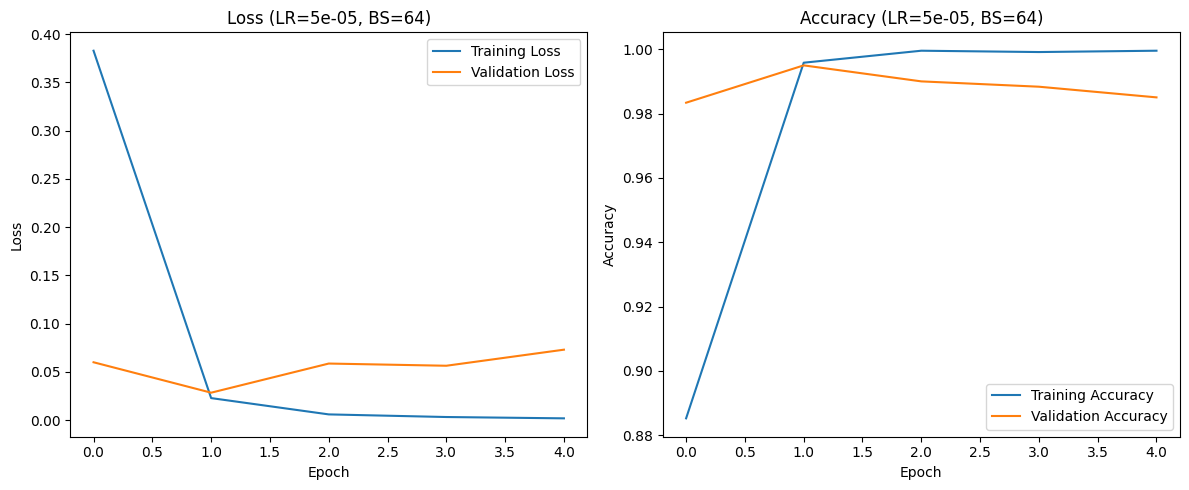


 Final Test Accuracy: 99.50%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.97      0.98        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       0.98      1.00      0.99       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 8.21 seconds

 Training with LR=2e-05, BS=16
Epoch  1, Train Loss: 0.3520, Acc: 0.9051, Val Loss: 0

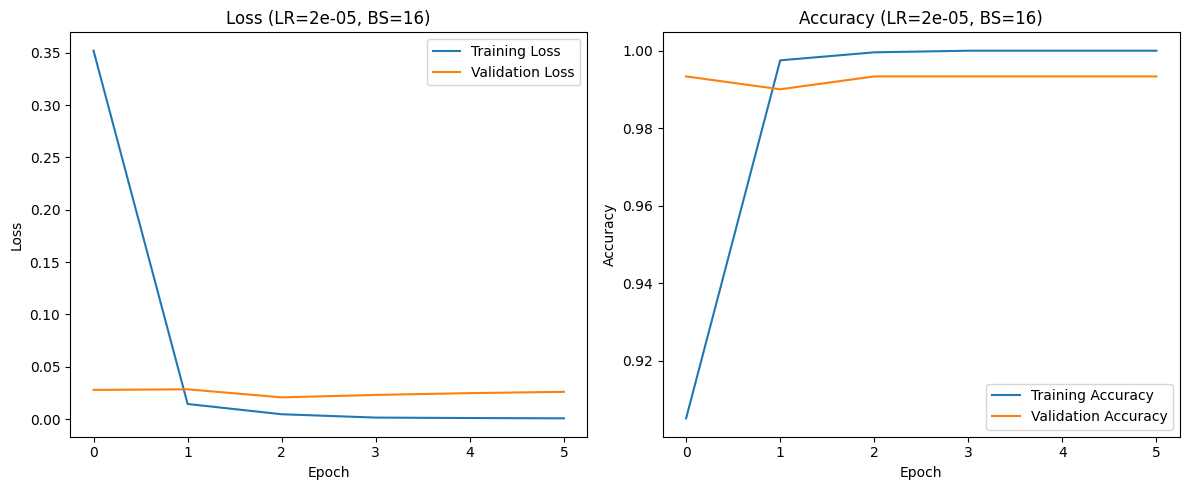


 Final Test Accuracy: 99.34%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       0.99      0.99      0.99        90
     call_contact       1.00      0.97      0.98        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.97      0.98        62
            query       1.00      1.00      1.00        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       0.98      1.00      0.99       122

         accuracy                           0.99       603
        macro avg       1.00      0.99      0.99       603
     weighted avg       0.99      0.99      0.99       603


 Response Time: 20.13 seconds

 Training with LR=2e-05, BS=32
Epoch  1, Train Loss: 0.4872, Acc: 0.8782, Val Loss: 

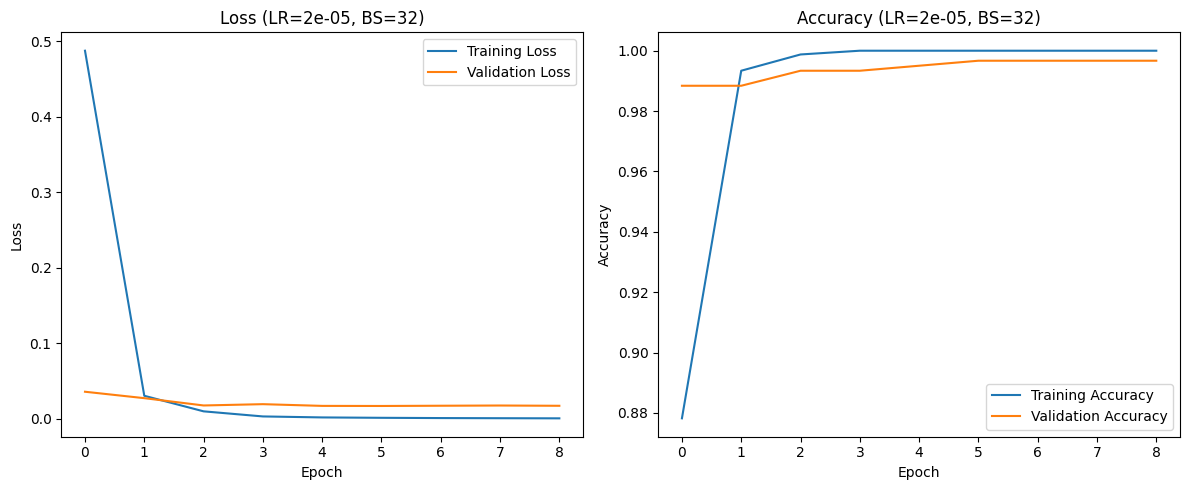


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.98      0.98        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      1.00      1.00       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 28.55 seconds

 Training with LR=2e-05, BS=64
Epoch  1, Train Loss: 0.8409, Acc: 0.7659, Val Loss: 

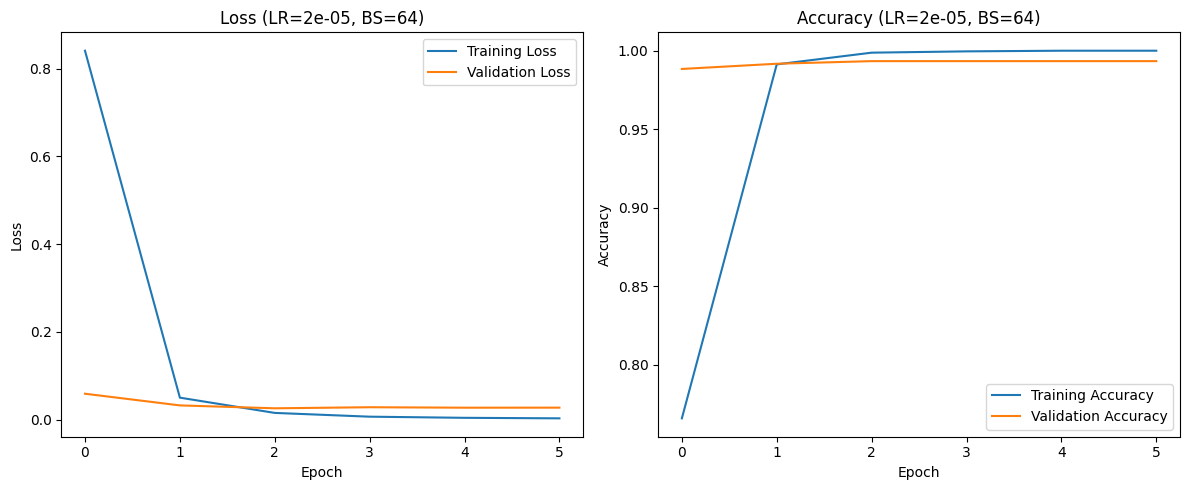


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.98      0.98        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      1.00      1.00       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 28.55 seconds

 Training with LR=1e-05, BS=16
Epoch  1, Train Loss: 0.6026, Acc: 0.8430, Val Loss: 

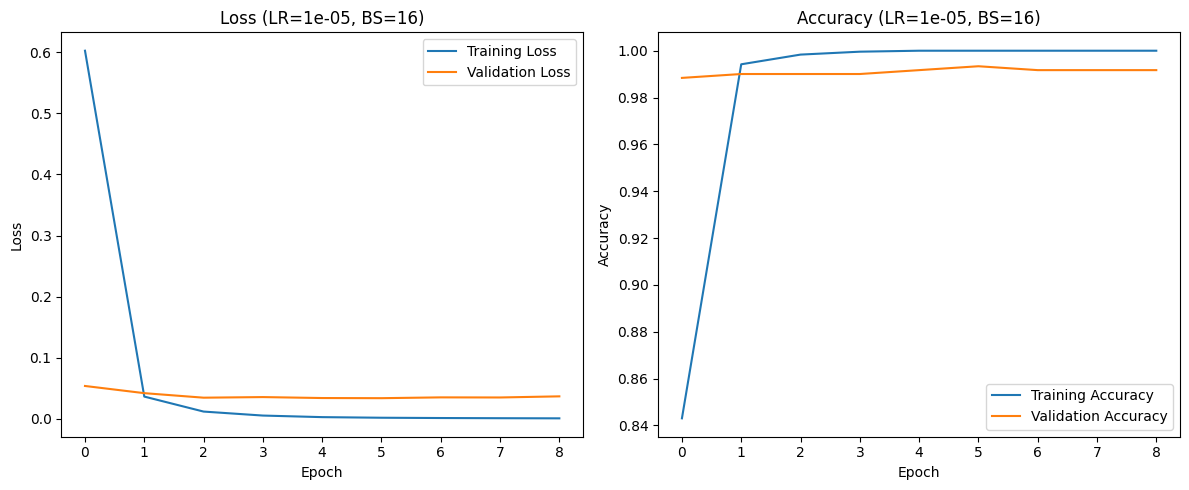


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.98      0.98        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      1.00      1.00       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 28.55 seconds

 Training with LR=1e-05, BS=32
Epoch  1, Train Loss: 0.8271, Acc: 0.7862, Val Loss: 

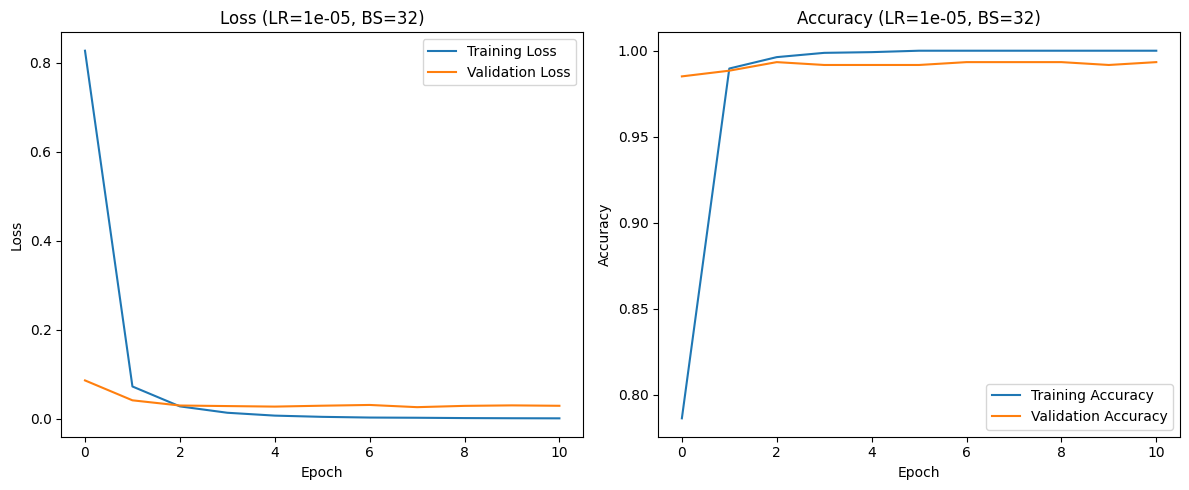


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.98      0.98        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      1.00      1.00       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 28.55 seconds

 Training with LR=1e-05, BS=64
Epoch  1, Train Loss: 1.1128, Acc: 0.6922, Val Loss: 

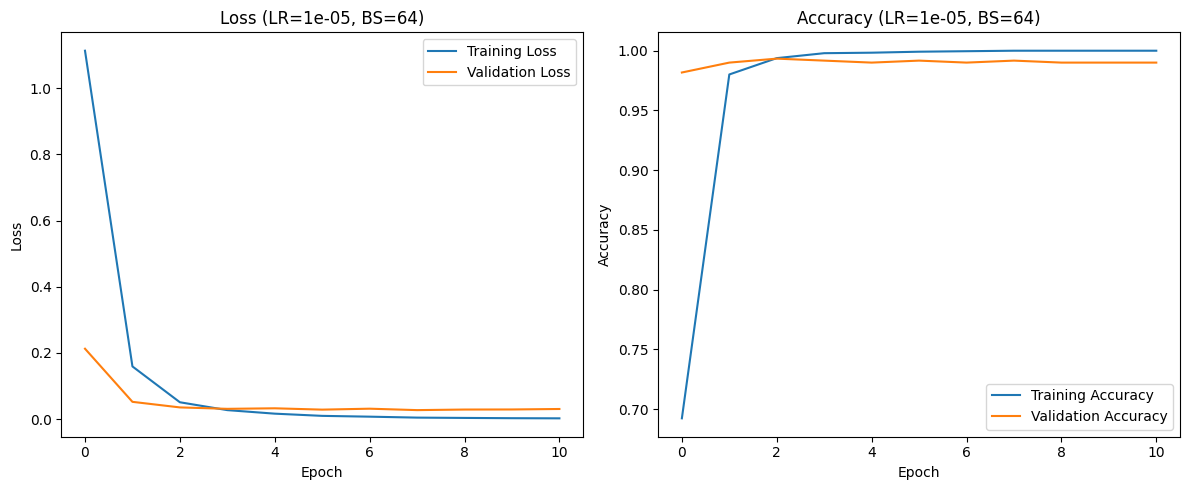


 Final Test Accuracy: 99.67%

 Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        42
     calendar_set       1.00      0.99      0.99        90
     call_contact       1.00      1.00      1.00        32
     camera_query       1.00      1.00      1.00        29
      iot_wemo_on       1.00      1.00      1.00        34
lists_createoradd       0.98      0.98      0.98        62
            query       0.99      1.00      0.99        68
     send_message       1.00      1.00      1.00        32
  transport_query       1.00      1.00      1.00        92
    weather_query       1.00      1.00      1.00       122

         accuracy                           1.00       603
        macro avg       1.00      1.00      1.00       603
     weighted avg       1.00      1.00      1.00       603


 Response Time: 28.55 seconds


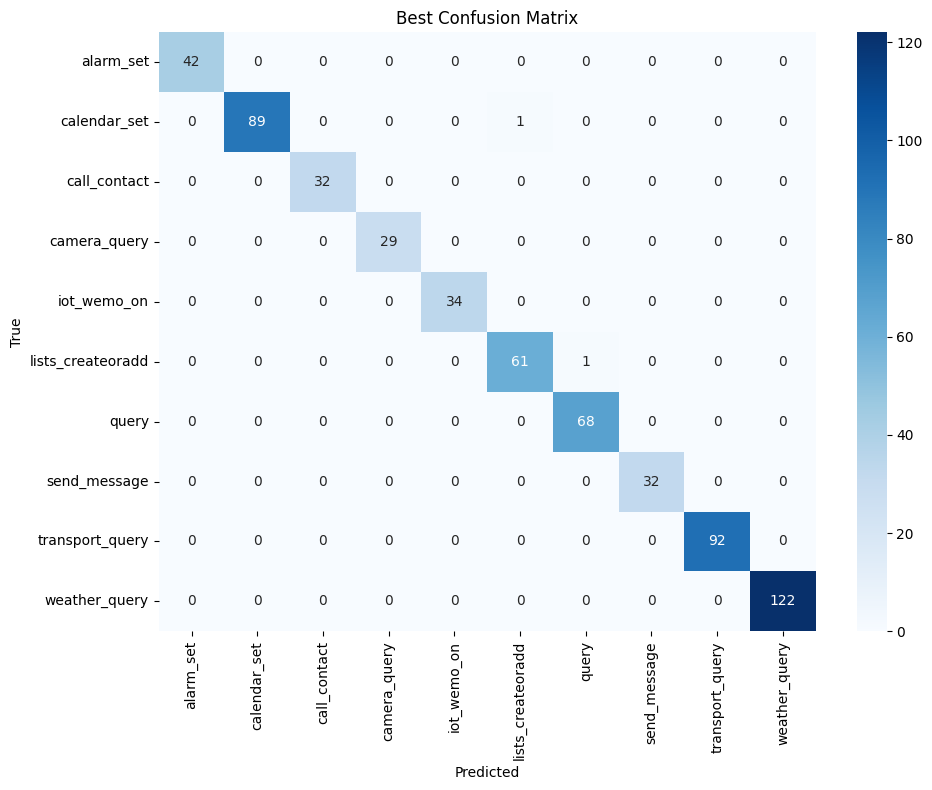

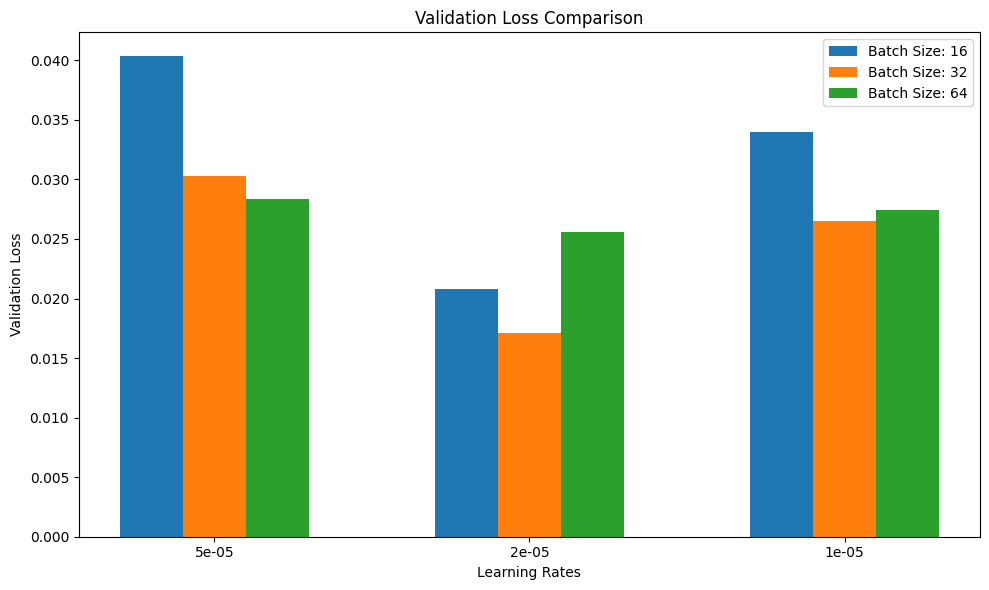

/tmp/ipykernel_1045249/1756765122.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))



📊 Cross-Validation Performance Summary:
Mean Macro F1: 0.9949 ± 0.0017
Mean Accuracy: 0.9947 ± 0.0018


In [ ]:
results = []
best_f1 = 0.0
best_model_overall = None
best_model_path_overall = ""
best_batch_size_overall = None

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in skf.split(X, y):
    print(f"\n========== Fold {fold} ==========")
    X_train_texts, X_val_texts = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    encoded_train = tokenizer(
        list(X_train_texts), padding=True, truncation=True, max_length=128,
        return_tensors='pt'
    )
    encoded_val = tokenizer(
        list(X_val_texts), padding=True, truncation=True, max_length=128,
        return_tensors='pt'
    )

    encoded_inputs_fold = {
        'input_ids': encoded_train['input_ids'],
        'attention_mask': encoded_train['attention_mask']
    }
    encoded_inputs_val_fold = {
        'input_ids': encoded_val['input_ids'],
        'attention_mask': encoded_val['attention_mask']
    }

    # Train using grid search
    best_model_path, best_batch_size, best_learning_rate  = run_grid_search(
        encoded_inputs_fold,
        y_train,
        encoded_inputs_val_fold,
        y_val,
        map_intent,
        base_model
    )

    # Evaluate model
    acc, f1, report_dict = evaluate_best_model(
        encoded_inputs_val_fold,
        y_val,
        map_intent,
        base_model,
        best_model_path,
        best_batch_size,
        return_metrics=True  # Make sure this function returns metrics
    )

    # Store results
    results.append({
        'fold': fold,
        'accuracy': acc,
        'macro_f1': f1,
        'model_path': best_model_path,
        'batch_size': best_batch_size,
        'learning_rate': best_learning_rate


    })

    # Update best model if this one is better
    if f1 > best_f1:
        best_f1 = f1
        best_model_overall = base_model
        best_model_path_overall = best_model_path
        best_batch_size_overall = best_batch_size

    fold += 1

# Export summary CSV
results_df = pd.DataFrame(results)
results_df.to_csv("cross_validation_results.csv", index=False)

# === Performance Summary Across Folds ===
mean_f1 = results_df['macro_f1'].mean()
std_f1 = results_df['macro_f1'].std()

mean_acc = results_df['accuracy'].mean()
std_acc = results_df['accuracy'].std()

print("\n📊 Cross-Validation Performance Summary:")
print(f"Mean Macro F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")



ביצוע הערכה סופית (Final Evaluation) של המודל הכי טוב שהתקבל מה־Cross Validation רק על משפטי הקשישים.

שמירת True Positives של המודל במקרים שסירי נכשלה (label == 0)

שמירה לקובץ CSV של המשפטים שהמודל זיהה נכון וסירי לא

In [ ]:
elderly_df = elderly_with_label

# Now apply it to the elderly data:
elderly_df["intent_num"] = le.transform(elderly_df["intent"])

# Create mapping from label index to intent name (if not already defined)
map_intent = dict(zip(le.transform(le.classes_), le.classes_))


In [ ]:
# Prepare input + labels
texts = elderly_df["transcript_hebrew"].tolist()
labels = elderly_df["intent_num"].tolist()

# Tokenize
encoded = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

# Create DataLoader
test_dataset = TensorDataset(
    encoded["input_ids"].clone().detach(),
    encoded["attention_mask"].clone().detach(),
    torch.tensor(labels, dtype=torch.long)
)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size_overall, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForIntentClassification(copy.deepcopy(base_model), num_classes=len(map_intent)).to(device)
model.load_state_dict(torch.load(best_model_path_overall))
model.eval()

# Predict + Evaluate
all_preds, all_labels = [], []
true_positive_rows = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        input_ids, attention_mask, y = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        for j in range(len(preds)):
            pred = preds[j].item()
            true = y[j].item()
            all_preds.append(pred)
            all_labels.append(true)

            row_index = i * best_batch_size_overall + j
            if row_index < len(elderly_df):
                row = elderly_df.iloc[row_index]
                if pred == true and row["label"] == 0:  # Siri failed
                    row_with_pred = row.copy()
                    row_with_pred["predicted_intent"] = map_intent[pred]
                    true_positive_rows.append(row_with_pred)

# Evaluation
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro")
intent_names = [map_intent[i] for i in sorted(set(all_labels + all_preds))]

print(f"\n🧓 Final Evaluation on Elderly Data:")
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Macro F1: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=intent_names))


/tmp/ipykernel_1045249/425248677.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path_overall))



🧓 Final Evaluation on Elderly Data:
Accuracy: 97.89%
Macro F1: 0.9825

Classification Report:
                   precision    recall  f1-score   support

        alarm_set       1.00      1.00      1.00        29
     calendar_set       1.00      1.00      1.00        29
     call_contact       0.96      0.96      0.96        27
     camera_query       1.00      1.00      1.00        15
      iot_wemo_on       1.00      1.00      1.00         9
lists_createoradd       1.00      1.00      1.00        22
            query       1.00      0.86      0.92        21
     send_message       1.00      0.95      0.97        19
  transport_query       0.93      1.00      0.97        57
    weather_query       1.00      1.00      1.00         9

         accuracy                           0.98       237
        macro avg       0.99      0.98      0.98       237
     weighted avg       0.98      0.98      0.98       237



שמירת הפקודות שזוהו במודל שלנו אך נכשלו בניסוי על ידי סירי לטובת ניסוח מחדש

In [ ]:
df_tp = pd.DataFrame(true_positive_rows)
df_siri_failed = elderly_df[elderly_df["label"] == 0]
matched_df = df_siri_failed[df_siri_failed["transcript_hebrew"].isin(df_tp["transcript_hebrew"])]
matched_df.to_csv("siri_failed_model_succeeded.csv", index=False, encoding="utf-8-sig")
